# Visualizing COVID-19 Data

This notebook is a small collection of examples on visualizing data of the ongoing pandemic of COVID-19. Data is pulled from [this repository](https://github.com/CSSEGISandData/COVID-19) which is updated regularly by the [Whiting School of Engineering of the Johns Hopkins University](https://systems.jhu.edu/research/public-health/ncov/).

## Getting Started
First, you need to get the repository this repository. You can either download it by [clicking here](https://github.com/aquilesC/Covid-19-Jupyter-Notebook/archive/master.zip) or by running the following on your terminal:

```bash
git clone git@github.com:aquilesC/Covid-19-Jupyter-Notebook.git Covid
```

The Data folder is actually another repository, pointing to the John Hopkins repository, therefore, you will need to enter into the ``Covid`` folder and do the following:

```bash
git submodule update --init --recursive
``` 
This will pull the data. Since the repository gets updated twice each day, before running the notebook, you should update the data by running the following, again directly from within the ``Covid`` folder:
```bash
git submodule update --recursive --remote
```

## Importing the modules

In [1]:
from datetime import datetime
import numpy as np
import os
import pandas as pd

We can now define the style of our plots. I like making big images with large fonts for axis to increase readability. I'm also setting the style to ``ggplot`` just to make different from standard matplotlib plots, but not because I particularly like it.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
plt.rcParams["figure.figsize"] = (14,9)
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 16

## Saving figures
I will use the parameter below to save the figures generated in this notebook. Every time a figure is generated, there will be an extra if-statement. This is useful when running the entire notebook just to make a new version of the plots with the data available

In [3]:
SAVE_FIGURES = True
# We store the Figures in one folder
if SAVE_FIGURES and not os.path.isdir('Figures') or not os.path.isdir('Figures/Es'):
    os.makedirs('Figures/Es')

## Data sources
We define the path to the files with the information we are interested int. I am using just the time series data which has the same information than the daily reports but aggregated. It also uses the cumulative numbers instead of the numbers of new cases. 

Starting **March 24th 2020**, they stopped providing updates to the number of recoveries, therefore we will need to rely only on the cummulative number of detected cases.

In [4]:
base_path = 'Data/csse_covid_19_data/csse_covid_19_time_series'
confirmed_file = os.path.join(base_path, 'time_series_covid19_confirmed_global.csv')
deaths_file = os.path.join(base_path, 'time_series_covid19_deaths_global.csv')

## Standardizing the data
We are going to load three different data sources: confirmed cases, deaths and recoveries. They all have the same format and we will apply some basic transofrmations to all the files. Hence, we abstract this to a function which is easier to maintain. 

We read the file (a csv file). We are not interested in the specific regions, but in studying trends at a country-level. We drop the columns with that information and also with the latitude/longitude coordinates, since we won't use them. Some countries have data split by state, such as in the case of China, and therefore we need to add it all up. Finally, the data is arranged in columns with the date, we transpose the dataframe in order to make it easier to work with. The final step is only transforming the index of the table to actual dates. 

In [5]:
def read_data_file(filename):
    data = pd.read_csv(filename)
    data = data.drop(['Province/State', 'Lat', 'Long'], axis=1)
    data = data.groupby(['Country/Region']).sum().transpose()
    data.index = pd.to_datetime(data.index)
    return data

In [6]:
confirmed_data = read_data_file(confirmed_file)
deaths_data = read_data_file(deaths_file)

The ``confirmed_data`` is the cumulative number of detected cases. However, it is much easier to understand if we only work with the number of new cases. For example, if we plot cumulative cases, the curve will never go down. At best, it will flatten out once no new cases appear. This is counter intuitive for most people. 

Therefore, we transform the confirmed number of cases to the differences betwen consecutive days. This gives just the number of new cases detected in every country.

In [7]:
sick_data = confirmed_data
new_cases = confirmed_data.diff()
new_cases_weekly = new_cases.rolling(7).sum()
new_cases_5_days = new_cases.rolling(5).sum()
new_deads = deaths_data.diff()
new_deads_weekly = deaths_data.rolling(7).sum()
new_deads_5_days = new_deads.rolling(5).sum()

## China
Let's see the information we have on China. Since we are plotting only one country, it is important to add the title, so we know what we are seeing. For more countries, the legend will do the job fine. 

## Doubling time
An interesting parameter to understand the evolution of the pandemic is to look at the doubling time in days. If we see that the doubling time increases, it means it will take longer for spreading the infection and therefore we would be effectively *bending the curve*.

First, I will construct a dataframe with the information. I align the data in such a way that todays data is calculated looking at past data, i.e. it is centered on the last datapoint used for fitting instead of the first or center value. 

I have to specify a winow, looking at 2 or 3 datapoints is too noisy. I setup a **10-day** window to calculate doubling rate. Since some days may show no increase, I remove all zeros from the data to fit, and only consider those sub-sets with at least **8 points** to fit. 

In [8]:
window_length = 10
doubling_time = {}
for country in list(new_cases):
    doubling_time[country] = np.zeros(len(new_cases)-window_length)
    for i in range(len(new_cases)-window_length):
        x = np.arange(0, window_length)
        y = new_cases[country][i:i+window_length].array
        to_delete = np.argwhere((y==0) | (np.isnan(y)))
        y = np.delete(y, to_delete)
        x = np.delete(x, to_delete)
        y = np.log2(y)
        if len(x)> 8:
            p = np.polyfit(x, y, 1)
            doubling_time[country][i] = 1/p[0]
        else:
            doubling_time[country][i] = np.nan
            
doubling_times_10_day = pd.DataFrame(index=new_cases.index[window_length:], data=doubling_time, columns=new_cases.columns)    

<ipython-input-8-196306beec0b>:11: RuntimeWarning: invalid value encountered in log2
  y = np.log2(y)


In [9]:
window_length = 5
doubling_time = {}
for country in list(new_cases):
    doubling_time[country] = np.zeros(len(new_cases)-window_length)
    for i in range(len(new_cases)-window_length):
        x = np.arange(0, window_length)
        y = new_cases[country][i:i+window_length].array
        to_delete = np.argwhere((y==0) | (np.isnan(y)))
        y = np.delete(y, to_delete)
        x = np.delete(x, to_delete)
        y = np.log2(y)
        if len(x)> 4:
            p = np.polyfit(x, y, 1)
            doubling_time[country][i] = 1/p[0]
        else:
            doubling_time[country][i] = np.nan
            
doubling_times_5_day = pd.DataFrame(index=new_cases.index[window_length:], data=doubling_time, columns=new_cases.columns)    

<ipython-input-9-430ac64b6681>:14: RuntimeWarning: divide by zero encountered in double_scalars
  doubling_time[country][i] = 1/p[0]
<ipython-input-9-430ac64b6681>:11: RuntimeWarning: invalid value encountered in log2
  y = np.log2(y)


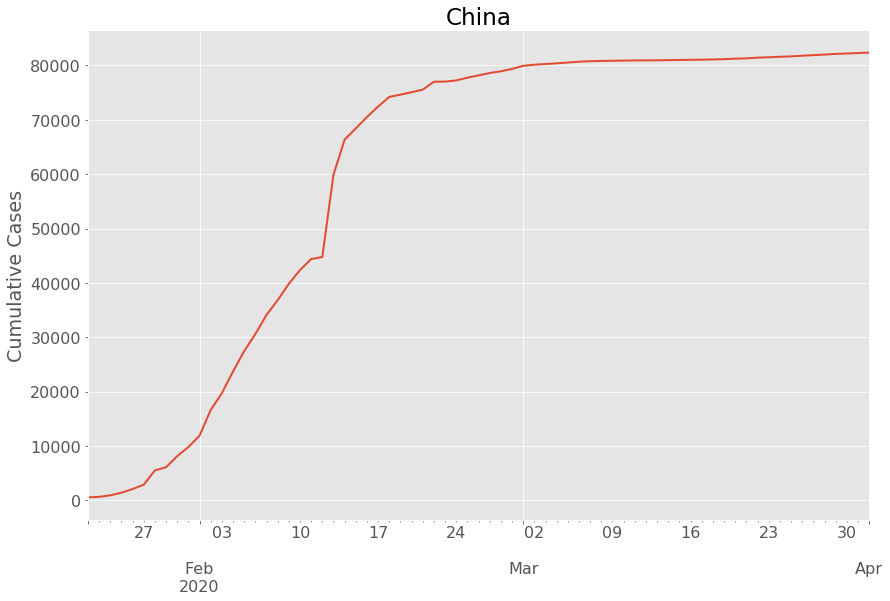

In [10]:
ax = sick_data['China'].plot(title='China')
ax.set_ylabel('Cumulative Cases')
if SAVE_FIGURES:
    plt.savefig('Figures/China_Lin_Lin.png')

With China we see the rapid growth of infections at the beginning of the year and how it declined in the last weeks. However, since the data spawns a lot of ranges (from close to 0 to almost 60000), it can be better to plot in in logarithmic scale:

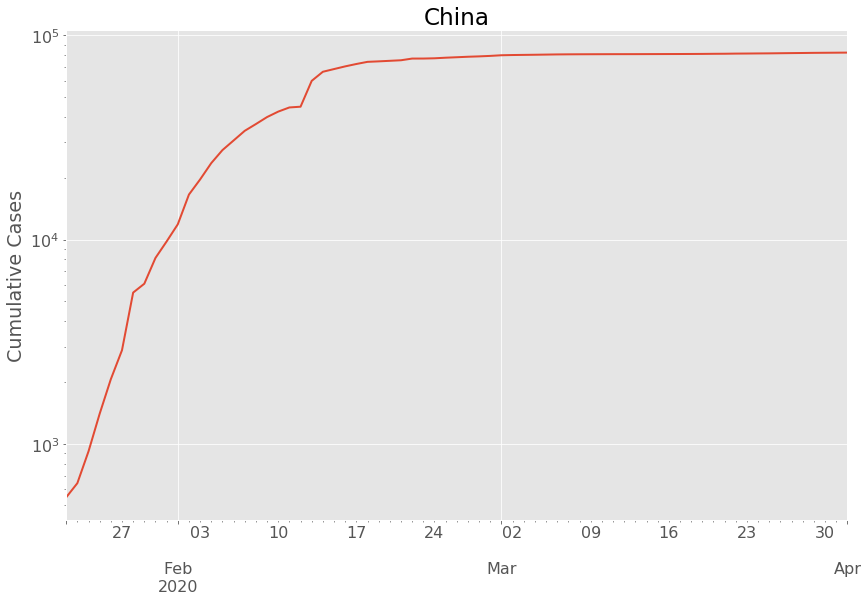

In [11]:
ax = sick_data['China'].plot(title='China', logy=True)
ax.set_ylabel('Cumulative Cases')
if SAVE_FIGURES:
    plt.savefig('Figures/China_Log_Lin.png')

## Comparing countries
Let's see how different countires compare over time. No normalizations, just the real data, in logarithmic scale.

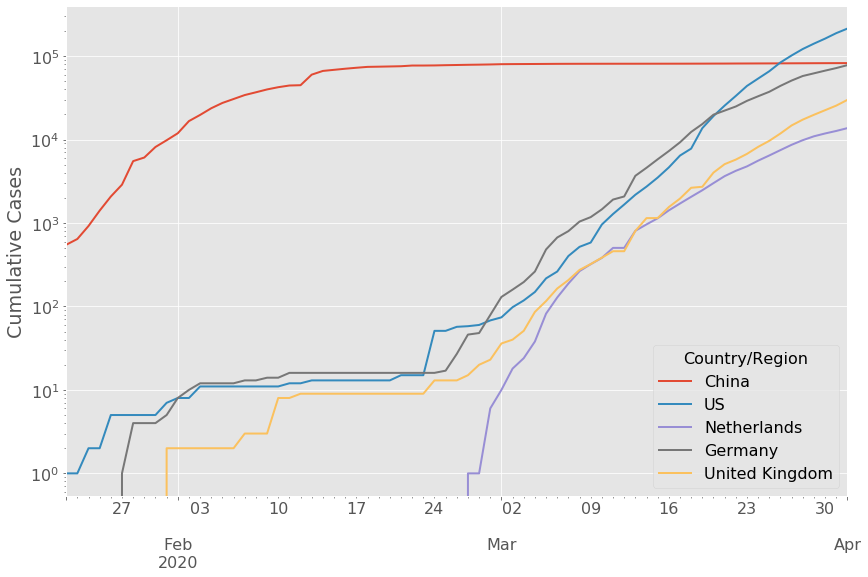

In [12]:
countries = ['China', 'US', 'Netherlands', 'Germany', 'United Kingdom']
ax = sick_data[countries].plot(logy=True)
ax.set_ylabel('Cumulative Cases')
if SAVE_FIGURES:
    plt.savefig('Figures/Country_comparison_log_lin.png')

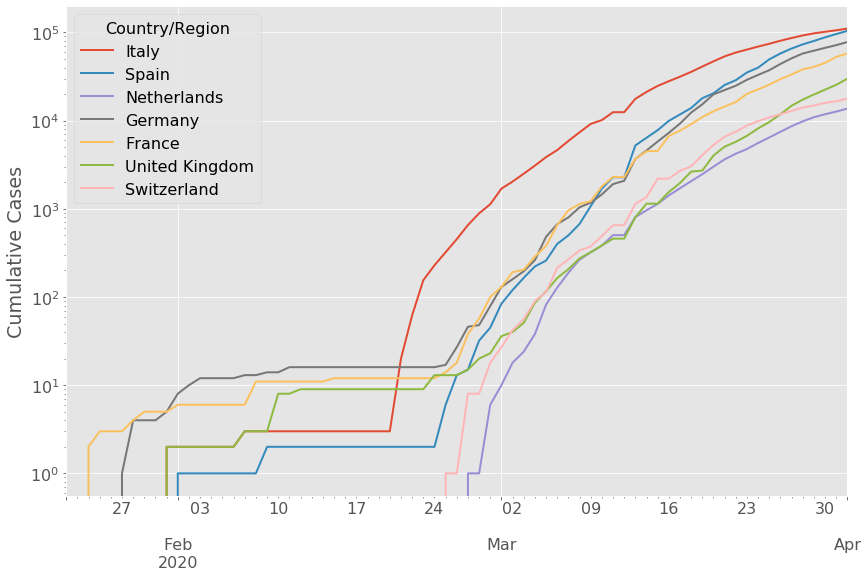

In [13]:
countries = ['Italy', 'Spain', 'Netherlands', 'Germany', 'France', 'United Kingdom', 'Switzerland']
ax = sick_data[countries].plot(logy=True)
ax.set_ylabel('Cumulative Cases')
if SAVE_FIGURES:
    plt.savefig('Figures/Europe_Log_Lin_01.png')

The trends above seem very similar but shifted by some days. We can try to make them overlap, in order to see if the trends are actually the same or if in some cases they are moving faster or slower. 

I will define the time shifts in a dictionary, to make them easier to edit and reuse in later parts of the code. I'm using **Italy** as a temporal reference because it is the country that was first hit very badly. 

In [14]:
time_shifts = {
    'Spain': 4,
    'Netherlands': 9,
    'Germany': 6,
    'United Kingdom': 6,
}

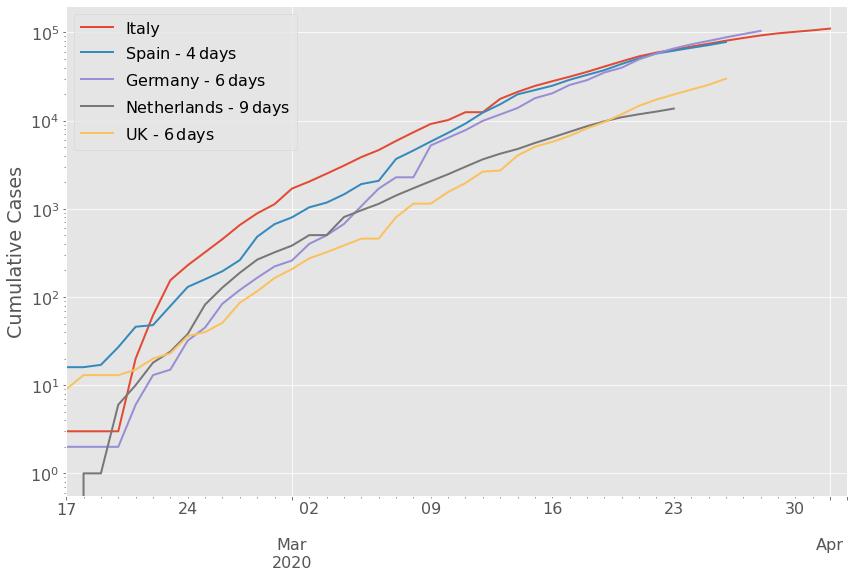

In [15]:
# Since I am altering the index in-place, each time I change the time-shift I need to copy the original data. 
italy = sick_data['Italy'].copy()
spain = sick_data['Spain'].copy()
germany = sick_data['Germany'].copy()
netherlands = sick_data['Netherlands'].copy()
uk = sick_data['United Kingdom'].copy()
spain.index -= pd.to_timedelta(time_shifts['Spain'], unit='d')
germany.index -= pd.to_timedelta(time_shifts['Germany'], unit='d')
netherlands.index -= pd.to_timedelta(time_shifts['Netherlands'], unit='d')
uk.index -= pd.to_timedelta(time_shifts['United Kingdom'], unit='d')
ax = italy.plot(logy=True)
germany.plot(ax=ax)
spain.plot(ax=ax)
netherlands.plot(ax=ax)
uk.plot(ax=ax)
ax.legend(['Italy', 
           f'Spain - {time_shifts["Spain"]}$\,$days', 
           f'Germany - {time_shifts["Germany"]}$\,$days', 
           f'Netherlands - {time_shifts["Netherlands"]}$\,$days',
           f'UK - {time_shifts["United Kingdom"]}$\,$days',
          ])
ax.set_xlim('2020-02-17', datetime.today())
ax.set_ylabel('Cumulative Cases')
if SAVE_FIGURES:
    plt.savefig('Figures/Europe_countries_shifted_log_lin.png')

We can also plot the lockdowns or quarentine measures in each country, taking into account the temporal shift of the previous plot. 

Since we are plotting  to the same axes, we lose control over the color cycle. Therefore, we can explicitly explore the color pallette and see which colors are being used. This is stored in ``plt.rcParams['axes.prop_cycle']``. Bear in mind that if you change the style of the plots, for example changing or removing the line ``plt.style.use('ggplot')``, the values below will also change and therefore the vertical lines will need to change as wel..

In [16]:
plt.rcParams['axes.prop_cycle']

'#E24A33'
'#348ABD'
'#988ED5'
'#777777'
'#FBC15E'
'#8EBA42'
'#FFB5B8'


In [17]:
lockdowns = {
    'Italy': datetime(2020, 3, 9),
    'Spain': datetime(2020, 3, 15),
    'Netherlands': datetime(2020, 3, 15),
    'Germany': datetime(2020, 3, 16),
    'Argentina': datetime(2020, 3, 20),
    'United Kingdom': datetime(2020, 3, 23),
}

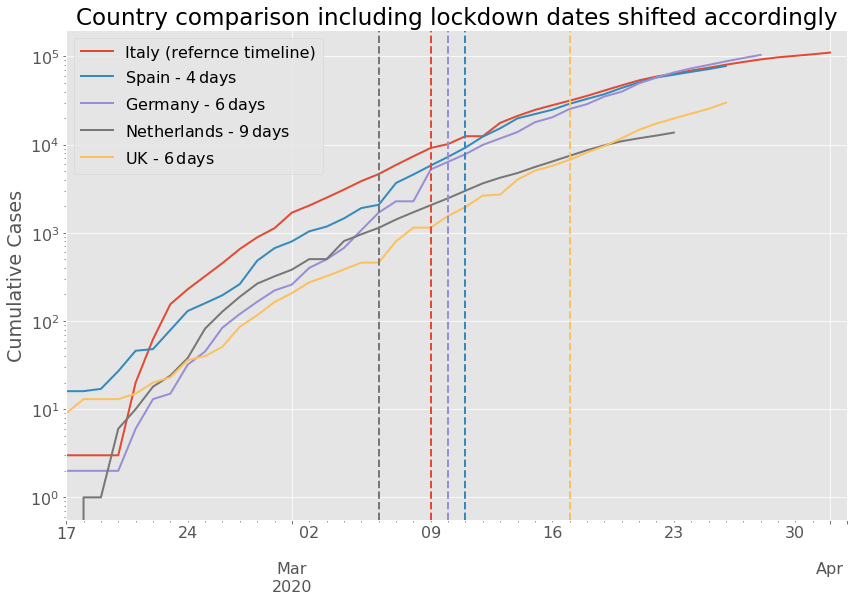

In [18]:
ax = italy.plot(logy=True, title='Country comparison including lockdown dates shifted accordingly')
germany.plot(ax=ax)
spain.plot(ax=ax)
netherlands.plot(ax=ax)
uk.plot(ax=ax)
ax.legend([
        'Italy (refernce timeline)', 
        f'Spain - {time_shifts["Spain"]}$\,$days', 
        f'Germany - {time_shifts["Germany"]}$\,$days', 
        f'Netherlands - {time_shifts["Netherlands"]}$\,$days',
        f'UK - {time_shifts["United Kingdom"]}$\,$days',
])
ax.set_xlim('2020-02-17', datetime.today())
ax.set_ylabel('Cumulative Cases')
ax.axvline(x=lockdowns['Italy'], linestyle='--')
ax.axvline(x=lockdowns['Spain']-pd.to_timedelta(time_shifts['Spain'], unit='d'), color='#348ABD', linestyle='--')
ax.axvline(x=lockdowns['Germany']-pd.to_timedelta(time_shifts['Germany'], unit='d'), color='#988ED5', linestyle='--')
ax.axvline(x=lockdowns['Netherlands']-pd.to_timedelta(time_shifts['Netherlands'], unit='d'), color='#777777', linestyle='--')
ax.axvline(x=lockdowns['United Kingdom']-pd.to_timedelta(time_shifts['United Kingdom'], unit='d'), color='#FBC15E', linestyle='--')
if SAVE_FIGURES:
    plt.savefig('Figures/Europe_countries_shifted_log_lin_with_lockdowns.png')

A lot of people struggle understanding semi-log plots, therefore, let's show the same data but in linear scale. 

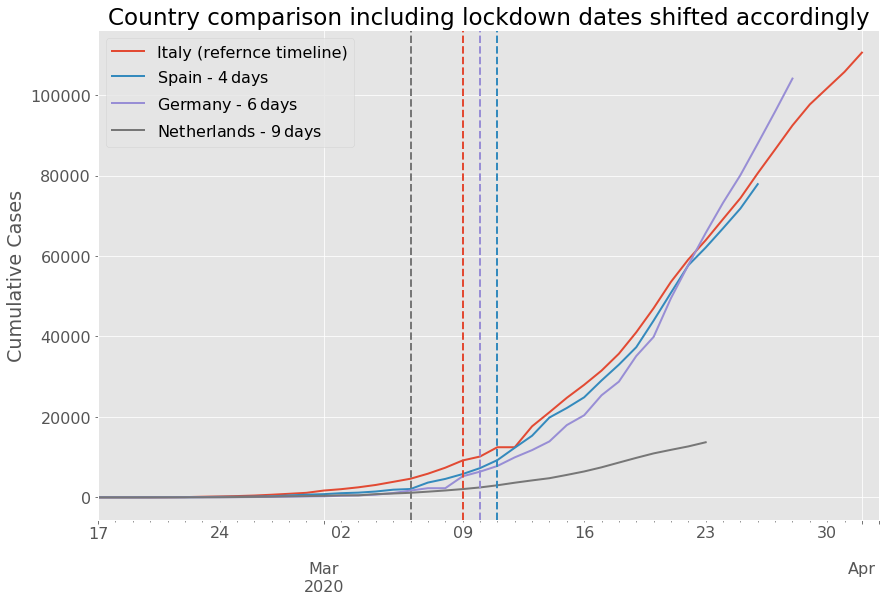

In [19]:
ax = italy.plot(logy=False, title='Country comparison including lockdown dates shifted accordingly')
germany.plot(ax=ax)
spain.plot(ax=ax)
netherlands.plot(ax=ax)
ax.legend(['Italy (refernce timeline)', 
           f'Spain - {time_shifts["Spain"]}$\,$days', 
           f'Germany - {time_shifts["Germany"]}$\,$days', 
           f'Netherlands - {time_shifts["Netherlands"]}$\,$days'])
ax.set_xlim('2020-02-17', datetime.today())
ax.set_ylabel('Cumulative Cases')
ax.axvline(x=lockdowns['Italy'], linestyle='--')
ax.axvline(x=lockdowns['Spain']-pd.to_timedelta(time_shifts['Spain'], unit='d'), color='#348ABD', linestyle='--')
ax.axvline(x=lockdowns['Germany']-pd.to_timedelta(time_shifts['Germany'], unit='d'), color='#988ED5', linestyle='--')
ax.axvline(x=lockdowns['Netherlands']-pd.to_timedelta(time_shifts['Netherlands'], unit='d'), color='#777777', linestyle='--')
if SAVE_FIGURES:
    plt.savefig('Figures/Europe_countries_shifted_lin_lin_with_lockdowns.png')

## Latin America
Some countries in Latin America are also interesting to observe. Mainly because they are following very different approaches to dealing with the virus. I'm also limiting the range of dates, because the first cases were detected relatively recently.

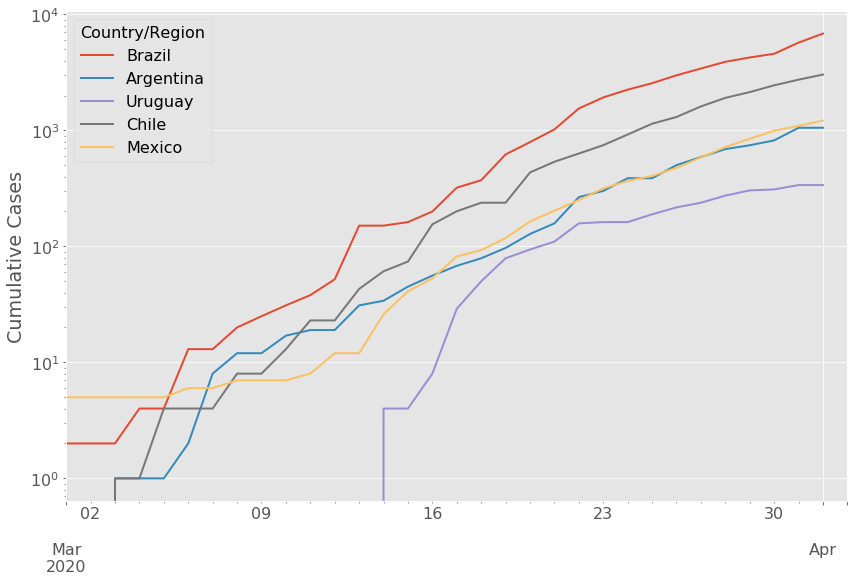

In [20]:
countries = ['Brazil', 'Argentina', 'Uruguay', 'Chile', 'Mexico']
ax = sick_data[countries].plot(logy=True)
ax.set_xlim('2020/03/01', datetime.today())
ax.set_ylabel('Cumulative Cases')
if SAVE_FIGURES:
    plt.savefig('Figures/Latin_America_Log_Lin.png')

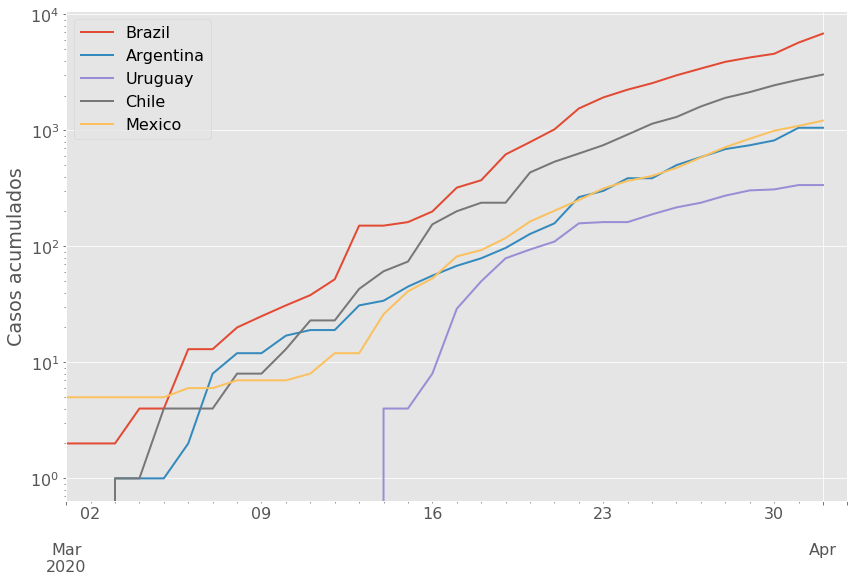

In [21]:
ax = sick_data[countries].plot(logy=True)
ax.set_xlim('2020/03/01', datetime.today())
ax.set_ylabel('Casos acumulados')
ax.legend(countries)
if SAVE_FIGURES:
    plt.savefig('Figures/Es/Latin_America_Log_Lin.png')

We can see how Argentina compares to Italy regarding spread and lockdown

In [22]:
time_shifts.update({'Argentina': 16})

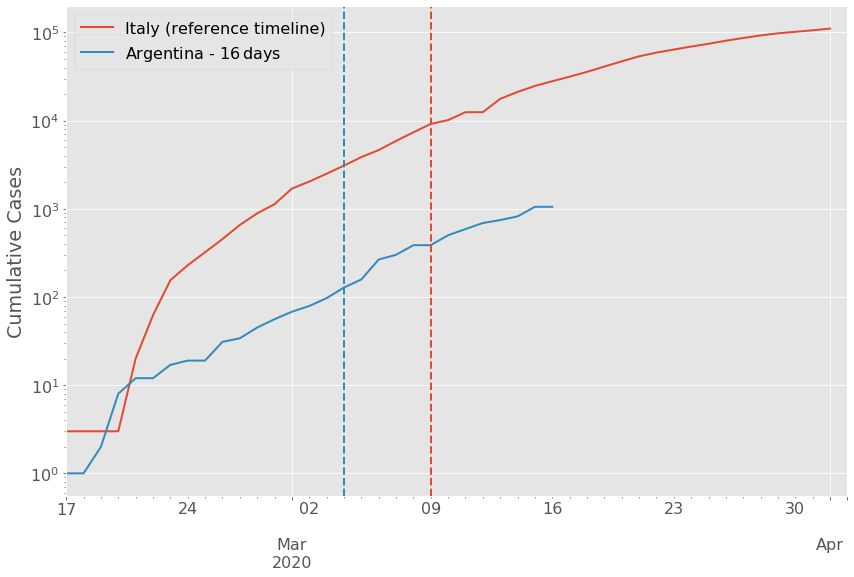

In [23]:
argentina = sick_data['Argentina'].copy()
argentina.index -= pd.to_timedelta(time_shifts['Argentina'], unit='d')
ax = italy.plot(logy=True)
argentina.plot(ax=ax)
ax.set_xlim('2020-02-17', datetime.today())
ax.legend([
    'Italy (reference timeline)',
    f'Argentina - {time_shifts["Argentina"]}$\,$days',
])
ax.axvline(x=lockdowns['Italy'], linestyle='--')
ax.axvline(x=lockdowns['Argentina']-pd.to_timedelta(time_shifts['Argentina'], unit='d'), color='#348ABD', linestyle='--')
ax.set_ylabel('Cumulative Cases')
if SAVE_FIGURES:
    plt.savefig('Figures/Argentina_Italy_log_lin_with_lockdowns.png')

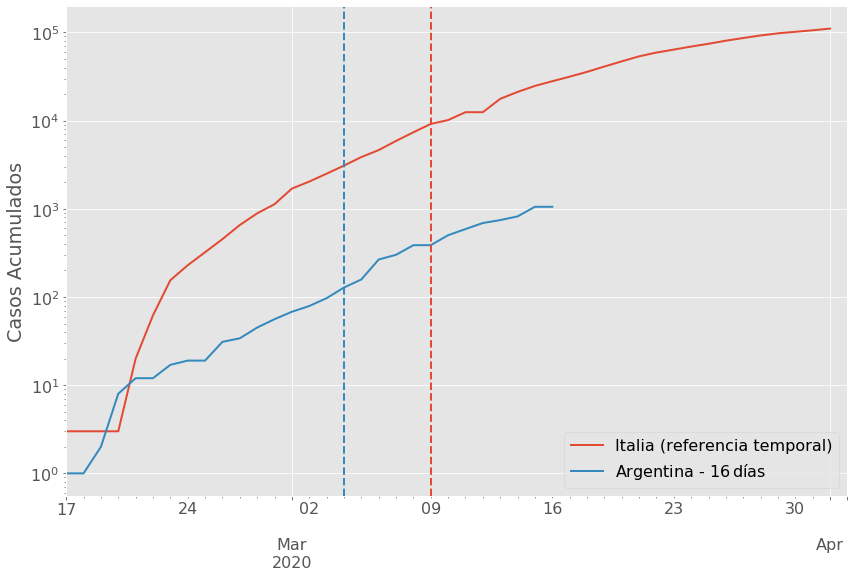

In [24]:
argentina = sick_data['Argentina'].copy()
argentina.index -= pd.to_timedelta(time_shifts['Argentina'], unit='d')
ax = italy.plot(logy=True)
argentina.plot(ax=ax)
ax.set_xlim('2020-02-17', datetime.today())
ax.legend([
    'Italia (referencia temporal)',
    f'Argentina - {time_shifts["Argentina"]}$\,$días',
])
ax.axvline(x=lockdowns['Italy'], linestyle='--')
ax.axvline(x=lockdowns['Argentina']-pd.to_timedelta(time_shifts['Argentina'], unit='d'), color='#348ABD', linestyle='--')
ax.set_ylabel('Casos Acumulados')
if SAVE_FIGURES:
    plt.savefig('Figures/Es/Argentina_Italy_log_lin_with_lockdowns.png')

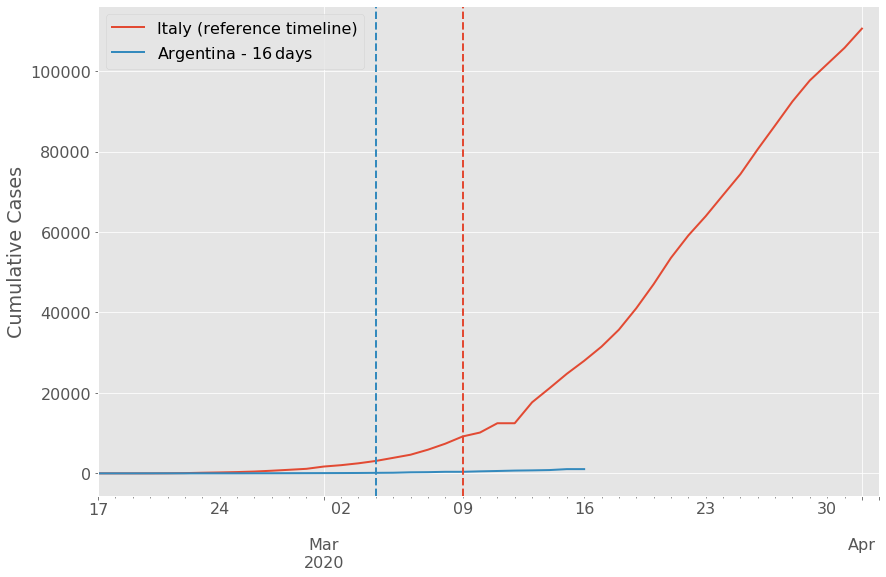

In [25]:
argentina = sick_data['Argentina'].copy()
argentina.index -= pd.to_timedelta(time_shifts['Argentina'], unit='d')
ax = italy.plot(logy=False)
argentina.plot(ax=ax)
ax.set_xlim('2020-02-17', datetime.today())
ax.legend([
    'Italy (reference timeline)',
    f'Argentina - {time_shifts["Argentina"]}$\,$days',
])
ax.axvline(x=lockdowns['Italy'], linestyle='--')
ax.axvline(x=lockdowns['Argentina']-pd.to_timedelta(time_shifts['Argentina'], unit='d'), color='#348ABD', linestyle='--')
ax.set_ylabel('Cumulative Cases')
if SAVE_FIGURES:
    plt.savefig('Figures/Argentina_Italy_lin_lin_with_lockdowns.png')

## Doubling time
These are very preliminary results. We can look at doubling time based on fitting the number of cases over a given window of time, and extracting the coefficient. The higher the value, the lower the spread. A negative value actually means the number of cases is decreasing. 

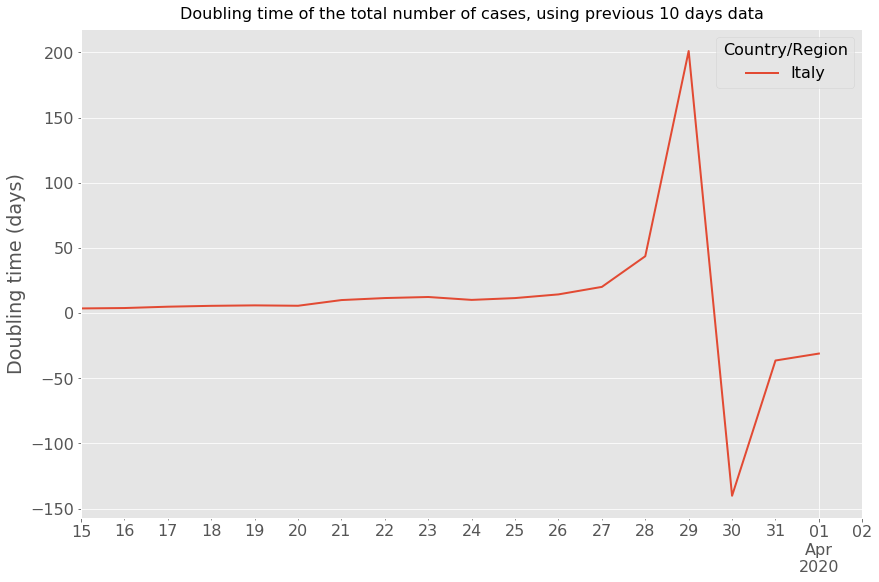

In [26]:
countries = ['Italy']
ax = doubling_times_10_day[countries].plot()
ax.set_xlim(datetime(2020,3,15), datetime.today())
ax.set_ylabel('Doubling time (days)')
title_text = 'Doubling time of the total number of cases, using previous 10 days data'
ax.text(0.5, 1.02, title_text, transform=ax.transAxes, horizontalalignment='center', fontsize=16)
if SAVE_FIGURES:
    plt.savefig('Figures/Doubling_Time_Ita_10_day.png')

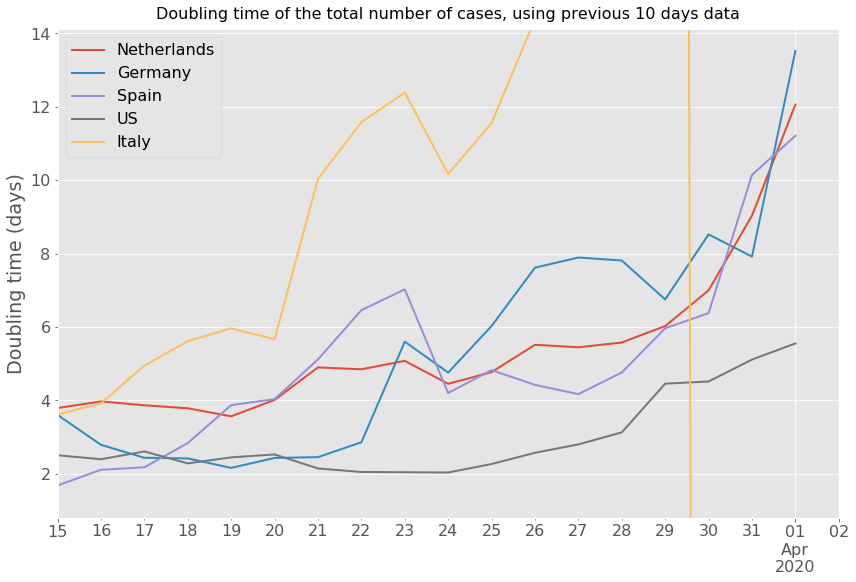

In [27]:
countries = ['Netherlands', 'Germany', 'Spain', 'US']
ax = doubling_times_10_day[countries].plot()
ylim = ax.get_ylim()
ax.set_ylabel('Doubling time (days)')
title_text = 'Doubling time of the total number of cases, using previous 10 days data'
doubling_times_10_day['Italy'].plot(ax=ax)
ax.set_ylim(ylim)
ax.set_xlim(datetime(2020,3,15), datetime.today())
ax.text(0.5, 1.02, title_text, transform=ax.transAxes, horizontalalignment='center', fontsize=16)
ax.legend(countries + ['Italy'])
if SAVE_FIGURES:
    plt.savefig('Figures/Doubling_Time_Net_Ger_Spa_US_Ita_10_day.png')

Doubling time if we use a 5-day window instead of a 10-day window

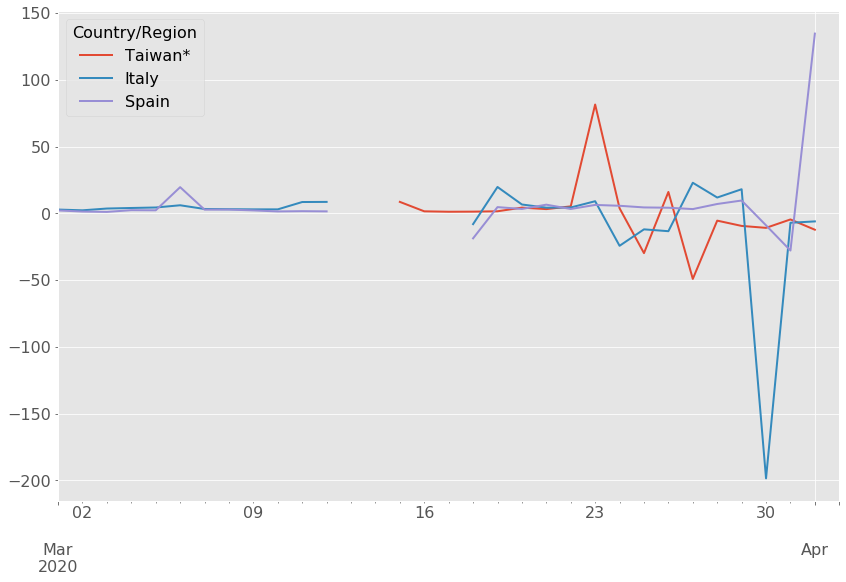

In [28]:
countries = ['Taiwan*', 'Italy', 'Spain']
ax = doubling_times_5_day[countries].plot()
ax.set_xlim(datetime(2020,3,1), datetime.today())
if SAVE_FIGURES:
    plt.savefig('Figures/Doubling_Time_Tai_Ita_Spa_5_day.png')

# Making plots of New cases vs accumulated cases
It was discussed that a better way of visualizing the evolution of the pandemic is to plot new cases versus accumulated cases. In this way we are actually plotting the derivative of the function and hence it is the proper way to see if there's any deviation from the exponential growth.

## Korea and China
Korea and China are two countries which are normally used as exemples of how to fight the epidemic. We can start by looking at their data, defining new cases as the increase of one day compared to the previous.

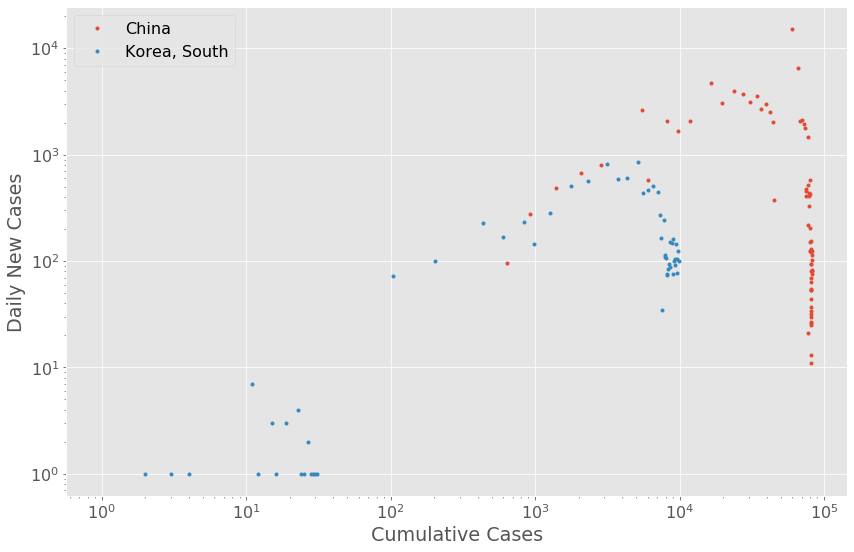

In [29]:
countries = ['China', 'Korea, South']
fig, ax = plt.subplots(1)
for country in countries:
    ax.plot(sick_data[country], new_cases[country],  '.')
ax.set_ylabel('Daily New Cases')
ax.set_xlabel('Cumulative Cases')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(countries)
if SAVE_FIGURES:
    plt.savefig('Figures/China_Korea_Log_Log_New_Cumulative.png')

It is possible to see that both curves grow at the same rate, but the data is very noisy. There are many possibilities of explaining this noise, especially when numbers are relatively low, and have weekly trends such as that in weekends perhaps less samples are processed. A simple way of lowering noise is by performing some sort of averaging, at the expense of loosing time-resolution. 

A **first** idea is to look at the number of weekly cases that lead to the increase of total cases. Each point now, is adding all the previous 7 days of data. The Data from China starts at around $10^3$ cases, and after removing the first 6 days, there's not as much data available from the beginning of the epidemic as there is for South Korea. 

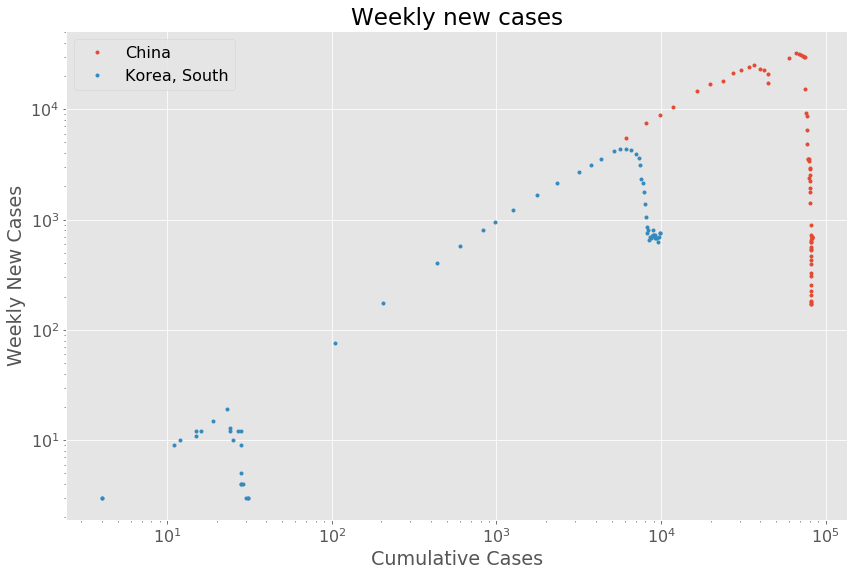

In [30]:
countries = ['China', 'Korea, South']
fig, ax = plt.subplots(1)
for country in countries:
    ax.plot(sick_data[country], new_cases_weekly[country],  '.')
ax.set_ylabel('Weekly New Cases')
ax.set_xlabel('Cumulative Cases')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(countries)
ax.set_title('Weekly new cases')
if SAVE_FIGURES:
    plt.savefig('Figures/China_Korea_Log_Log_New_Cumulative_weekly.png')

## 5-Day new cases

Looking at the weekly cases makes the data smoother, but it also loses temporal resolution, and it may take too long for a new detail to emerge, such as a plateauing of the number of new cases. In the same spirit as before, we can look at the number of cases in the previous 5 days. This should make the data smooth enough to see the trend and sensitive enough to changes. Of course, the **5-day** parameter can be varied to see what suits best the analysis at hand. 

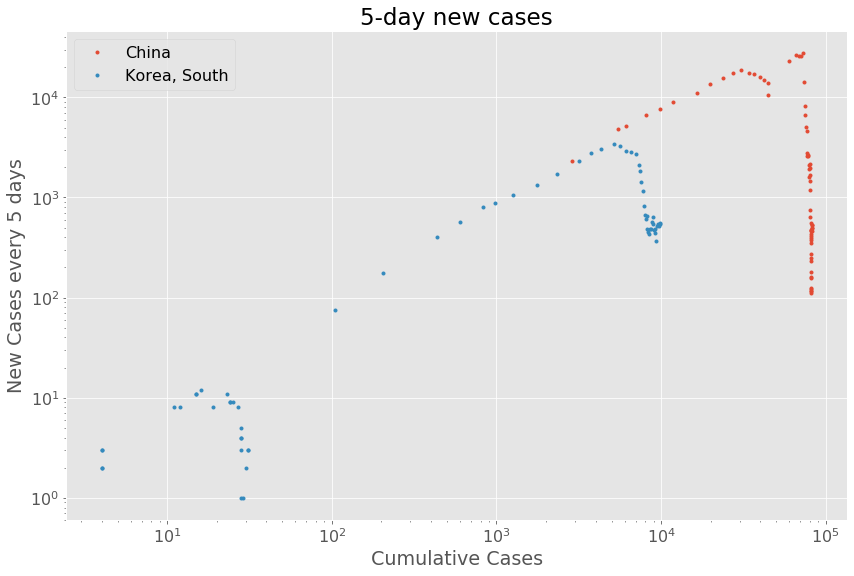

In [31]:
countries = ['China', 'Korea, South']
fig, ax = plt.subplots(1)
for country in countries:
    ax.plot(sick_data[country], new_cases_5_days[country],  '.')
ax.set_ylabel('New Cases every 5 days')
ax.set_xlabel('Cumulative Cases')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('5-day new cases')
ax.legend(countries)
if SAVE_FIGURES:
    plt.savefig('Figures/China_Korea_Log_Log_New_Cumulative_5_days.png')

## World Comparison
Let's see how some paradigmatic countries compare. It is possible to observe that they all overlap during the exponential growth until they don't anymore. I suspect that some fluctuations such as those of Iran may be due to sampling and reporting inaccuracies. However, it is clear that Italy is departing from the exponential growth. 

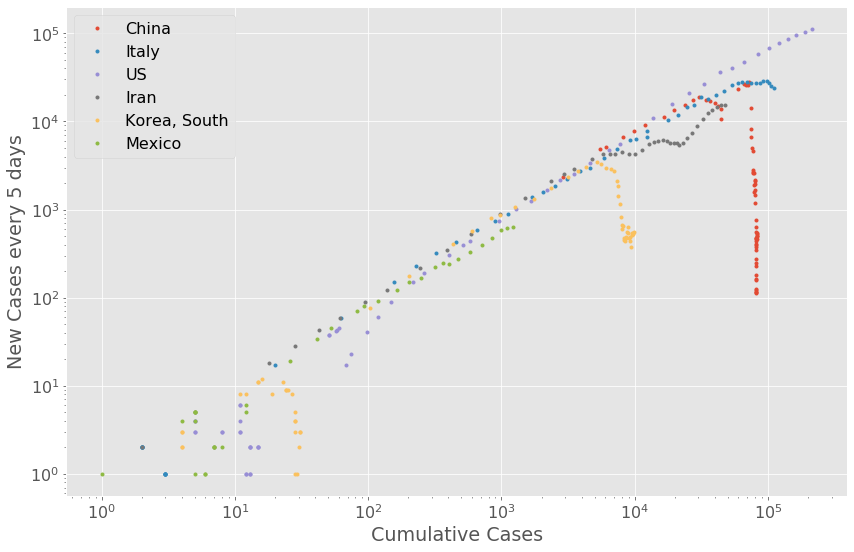

In [32]:
countries = ['China', 'Italy', 'US', 'Iran', 'Korea, South', 'Mexico']
fig, ax = plt.subplots(1)
for country in countries:
    ax.plot(sick_data[country], new_cases_5_days[country],  '.')
ax.set_ylabel('New Cases every 5 days')
ax.set_xlabel('Cumulative Cases')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(countries)
if SAVE_FIGURES:
    plt.savefig('Figures/Countries_Log_Log_New_Cumulative_5_days.png')

## Data of the US as base line
The data from the US is the one that better shows the exponential growth for a large range of values. Therefore, we can use it as a reference to compare the progress in other countries. 

I will fit the data of the US by a polynomial of degree 1, in logarithmic scale. This inforation will be stored and used as a reference for later plots.

/opt/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


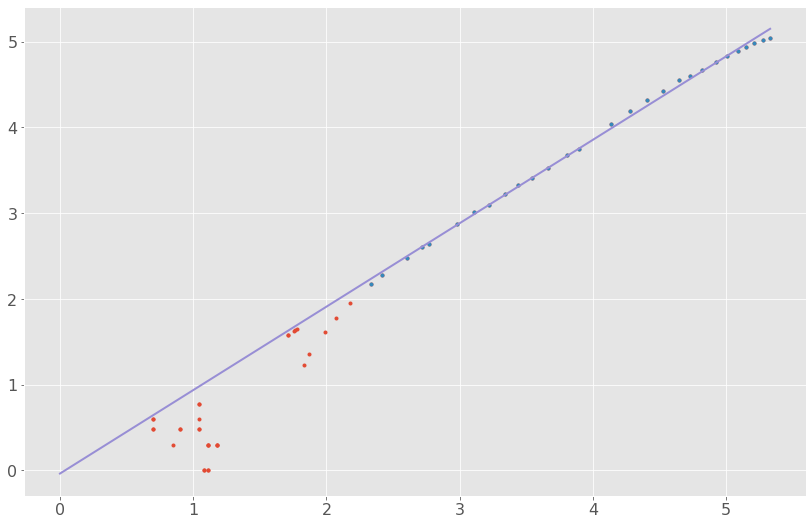

In [33]:
country = 'US'
to_fit_x = np.log10(sick_data[country])
to_fit_y = np.log10(new_cases_5_days[country])
us_fit = np.polyfit(to_fit_x[43:], to_fit_y[43:], 1)
plt.plot(to_fit_x, to_fit_y, '.')
plt.plot(to_fit_x[43:], to_fit_y[43:], '.')
plot_range = (0, max(to_fit_x))
plt.plot(plot_range, np.polyval(us_fit, plot_range), '-')

## World comparison with reference line
We can make the plot again of some relevant countries and see how they **compare to the data from the US**. They all show the same trend at the beginning, until they slowly start departing from it. 

Countries such as **Italy**, **Spain**, and **Switzerland** are showing that the growth rate is not increasing anymore and, in some cases, one could argue it is actually decreasing. 

However, the behavior of **Denmark** and **Sweden** is very hard to explain without more information. I suspect it can be that they changed their policies regarding testing, for example. 

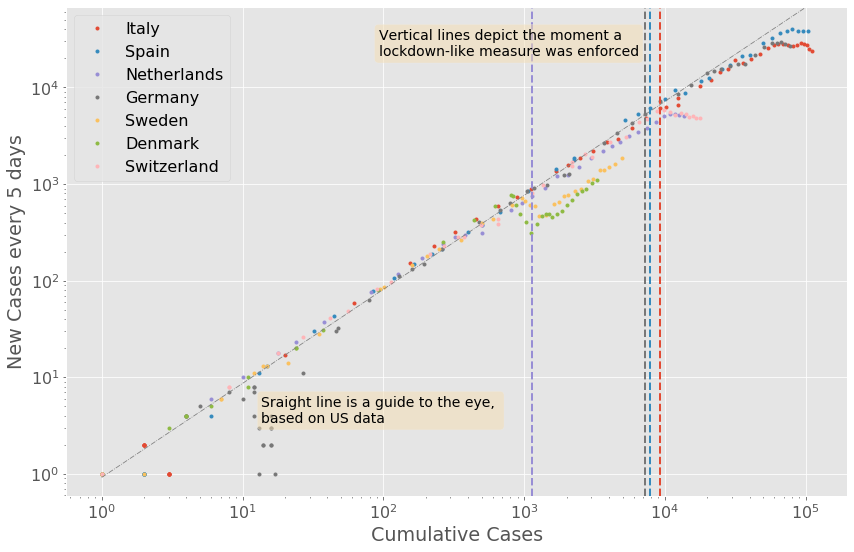

In [34]:
countries = ['Italy', 'Spain', 'Netherlands', 'Germany', 'Sweden', 'Denmark', 'Switzerland']
fig, ax = plt.subplots(1)
for country in countries:
    ax.plot(sick_data[country], new_cases_5_days[country],  '.')
ax.set_ylabel('New Cases every 5 days')
ax.set_xlabel('Cumulative Cases')
ax.set_yscale('log')
ax.set_xscale('log')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot((1, 1E6), 10**np.polyval(us_fit, (0, 6)), '-.', linewidth=.8, color='grey')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend(countries)

for i, country in enumerate(countries):
    if country in lockdowns:
        ld = sick_data[country][lockdowns[country]]
        ax.axvline(x=ld, linestyle='--', color=list(plt.rcParams['axes.prop_cycle'])[i]['color'])

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
text = 'Sraight line is a guide to the eye, \nbased on US data'
t = ax.text(.25, .15, text, transform=ax.transAxes, fontsize=14, bbox=props)
lockdown_text = 'Vertical lines depict the moment a \nlockdown-like measure was enforced'
t1 = ax.text(.4, .9, lockdown_text, transform=ax.transAxes, fontsize=14, bbox=props)
if SAVE_FIGURES:
    plt.savefig('Figures/Europe_Log_Log_New_Cumulative_5_days.png')

### Italy, Spain, Switzerland
These three countries seem to be controlling, finally, the outbreak. It is clear that the newest points are trully departing from the exponential, even though growth rates are still not decreasing. 

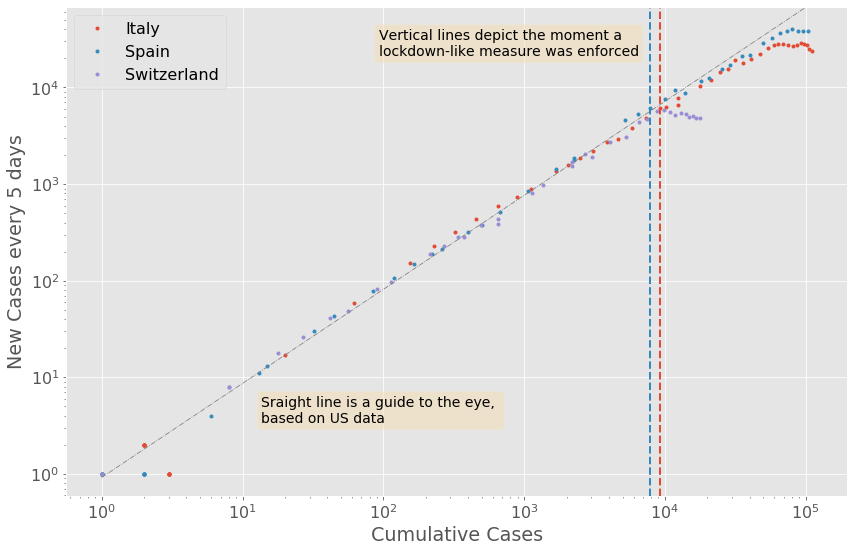

In [35]:
countries = ['Italy', 'Spain', 'Switzerland']
fig, ax = plt.subplots(1)
for country in countries:
    ax.plot(sick_data[country], new_cases_5_days[country],  '.')        
ax.set_ylabel('New Cases every 5 days')
ax.set_xlabel('Cumulative Cases')
ax.set_yscale('log')
ax.set_xscale('log')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot((1, 1E6), 10**np.polyval(us_fit, (0, 6)), '-.', linewidth=.8, color='grey')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend(countries)

for i, country in enumerate(countries):
    if country in lockdowns:
        ld = sick_data[country][lockdowns[country]]
        ax.axvline(x=ld, linestyle='--', color=list(plt.rcParams['axes.prop_cycle'])[i]['color'])

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
text = 'Sraight line is a guide to the eye, \nbased on US data'
t = ax.text(.25, .15, text, transform=ax.transAxes, fontsize=14, bbox=props)
lockdown_text = 'Vertical lines depict the moment a \nlockdown-like measure was enforced'
t1 = ax.text(.4, .9, lockdown_text, transform=ax.transAxes, fontsize=14, bbox=props)
if SAVE_FIGURES:
    plt.savefig('Figures/Europe_Ita_Spa_Swi_Log_Log_New_Cumulative_5_days.png')

In [36]:
list(plt.rcParams['axes.prop_cycle'])[0]['color']

'#E24A33'

### Netherlands, Germany, United Kingdom
Countries more to the north in Europe have a different trend. The **UK** and **Germany** have followed an exponential growth in the number of cases for a longer period. Germany seems to be slowly departing from that trend, and the number of new cases seems to be plateauing. **The Netherlands** managed to have a slower growth compared to the US and may be slowing down the increase in numbers, but it is too early to draw any conclusions. 

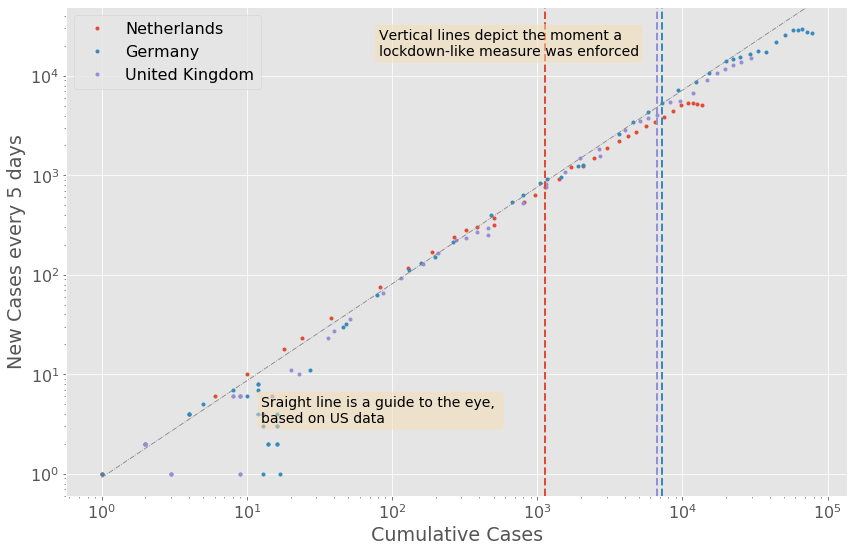

In [37]:
countries = ['Netherlands', 'Germany', 'United Kingdom']
fig, ax = plt.subplots(1)
for country in countries:
    ax.plot(sick_data[country], new_cases_5_days[country],  '.')
ax.set_ylabel('New Cases every 5 days')
ax.set_xlabel('Cumulative Cases')
ax.set_yscale('log')
ax.set_xscale('log')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot((1, 1E6), 10**np.polyval(us_fit, (0, 6)), '-.', linewidth=.8, color='grey')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend(countries)

for i, country in enumerate(countries):
    if country in lockdowns:
        ld = sick_data[country][lockdowns[country]]
        ax.axvline(x=ld, linestyle='--', color=list(plt.rcParams['axes.prop_cycle'])[i]['color'])

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
text = 'Sraight line is a guide to the eye, \nbased on US data'
t = ax.text(.25, .15, text, transform=ax.transAxes, fontsize=14, bbox=props)
lockdown_text = 'Vertical lines depict the moment a \nlockdown-like measure was enforced'
t1 = ax.text(.4, .9, lockdown_text, transform=ax.transAxes, fontsize=14, bbox=props)
if SAVE_FIGURES:
    plt.savefig('Figures/Europe_Net_Ger_UK_Log_Log_New_Cumulative_5_days.png')

## Plot in Linear Scale
Showing the same data in linear scale may have a better visual representation of what is happening in the last few days. It is easier to see the magnitude of the number of cases and how quickly they can change.

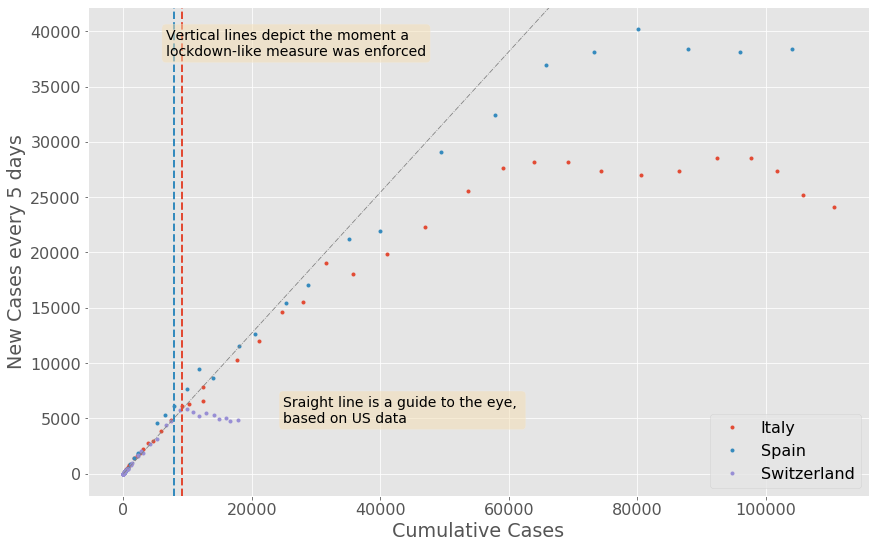

In [38]:
countries = ['Italy', 'Spain', 'Switzerland']
fig, ax = plt.subplots(1)
for country in countries:
    ax.plot(sick_data[country], new_cases_5_days[country],  '.')
ax.set_ylabel('New Cases every 5 days')
ax.set_xlabel('Cumulative Cases')
ax.legend(countries)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot((1, 1E6), 10**np.polyval(us_fit, (0, 6)), '-.', linewidth=.8, color='grey')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend(countries)

for i, country in enumerate(countries):
    if country in lockdowns:
        ld = sick_data[country][lockdowns[country]]
        ax.axvline(x=ld, linestyle='--', color=list(plt.rcParams['axes.prop_cycle'])[i]['color'])

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
text = 'Sraight line is a guide to the eye, \nbased on US data'
t = ax.text(.25, .15, text, transform=ax.transAxes, fontsize=14, bbox=props)
lockdown_text = 'Vertical lines depict the moment a \nlockdown-like measure was enforced'
t1 = ax.text(.1, .9, lockdown_text, transform=ax.transAxes, fontsize=14, bbox=props)
if SAVE_FIGURES:
    plt.savefig('Figures/Europe_Ita_Spa_Swi_Lin_Lin_New_Cumulative_5_days.png')

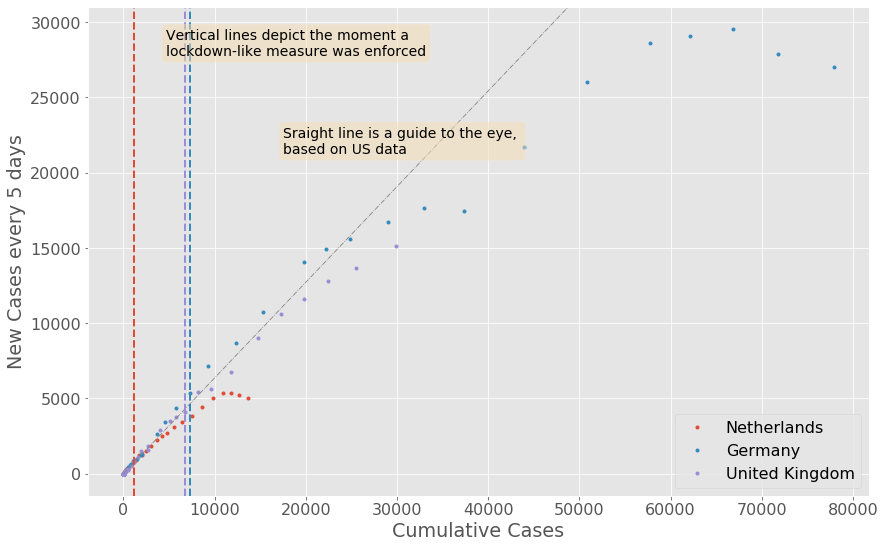

In [39]:
countries = ['Netherlands', 'Germany', 'United Kingdom']
fig, ax = plt.subplots(1)
for country in countries:
    ax.plot(sick_data[country], new_cases_5_days[country],  '.')
ax.set_ylabel('New Cases every 5 days')
ax.set_xlabel('Cumulative Cases')
ax.legend(countries)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot((1, 1E6), 10**np.polyval(us_fit, (0, 6)), '-.', linewidth=.8, color='grey')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend(countries)

for i, country in enumerate(countries):
    if country in lockdowns:
        ld = sick_data[country][lockdowns[country]]
        ax.axvline(x=ld, linestyle='--', color=list(plt.rcParams['axes.prop_cycle'])[i]['color'])

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
text = 'Sraight line is a guide to the eye, \nbased on US data'
t = ax.text(.25, .7, text, transform=ax.transAxes, fontsize=14, bbox=props)
lockdown_text = 'Vertical lines depict the moment a \nlockdown-like measure was enforced'
t1 = ax.text(.1, .9, lockdown_text, transform=ax.transAxes, fontsize=14, bbox=props)
if SAVE_FIGURES:
    plt.savefig('Figures/Europe_Net_Ger_UK_Lin_Lin_New_Cumulative_5_days.png')

## Latin America
Some representative countries of the evolution of the pandemic in the continent are **Argentina**, **Brazil**, **Chile**, and **Mexico**. All the countries are showing the same progress with some mild departures from exponential growth in cases such as Argentina and Chile. Brazil is shwoing a very peculiar behavior, which I think can be attributed to saturating the testing capacity or negligence.

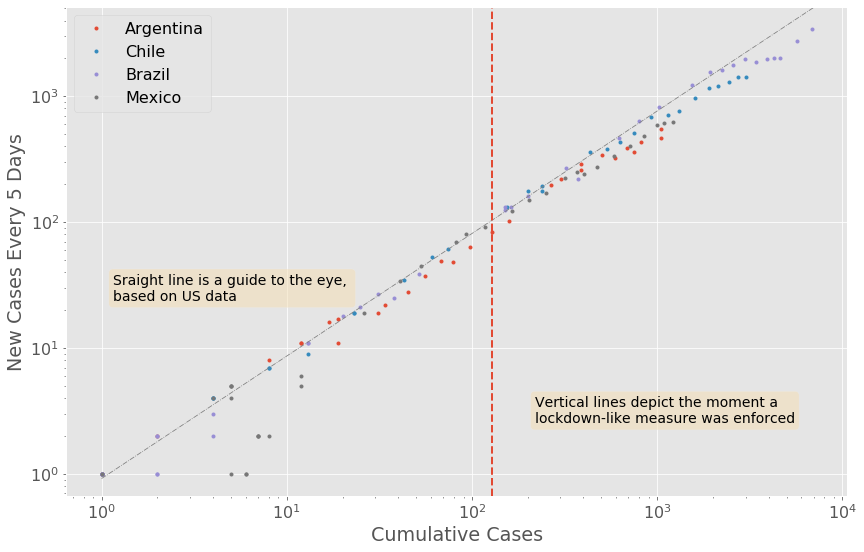

In [40]:
countries = ['Argentina', 'Chile', 'Brazil', 'Mexico']
fig, ax = plt.subplots(1)
for country in countries:
    ax.plot(sick_data[country], new_cases_5_days[country],  '.')
ax.set_ylabel('New Cases Every 5 Days')
ax.set_xlabel('Cumulative Cases')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(countries)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot((1, 1E6), 10**np.polyval(us_fit, (0, 6)), '-.', linewidth=.8, color='grey')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend(countries)

for i, country in enumerate(countries):
    if country in lockdowns:
        ld = sick_data[country][lockdowns[country]]
        ax.axvline(x=ld, linestyle='--', color=list(plt.rcParams['axes.prop_cycle'])[i]['color'])

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
text = 'Sraight line is a guide to the eye, \nbased on US data'
t = ax.text(.06, .4, text, transform=ax.transAxes, fontsize=14, bbox=props)
lockdown_text = 'Vertical lines depict the moment a \nlockdown-like measure was enforced'
t1 = ax.text(.6, .15, lockdown_text, transform=ax.transAxes, fontsize=14, bbox=props)
if SAVE_FIGURES:
    plt.savefig('Figures/Latin_America_Log_Log_New_Cumulative_5_days.png')

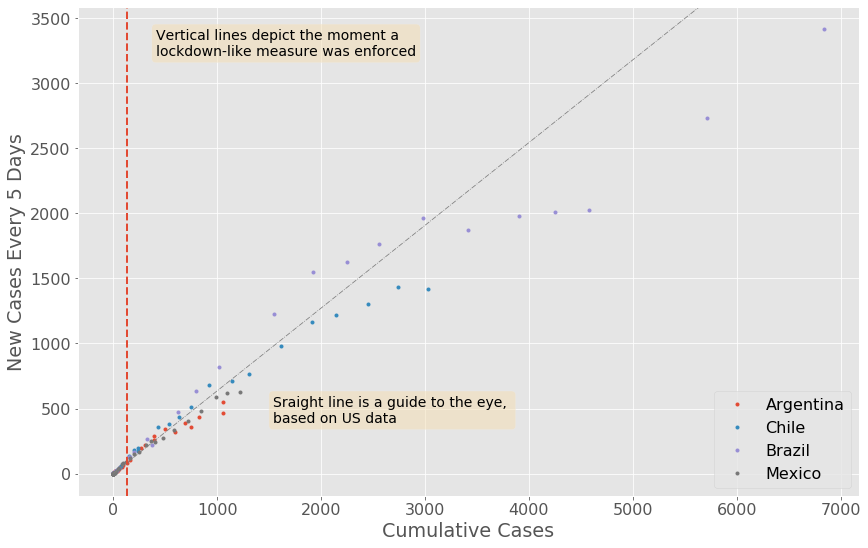

In [41]:
countries = ['Argentina', 'Chile', 'Brazil', 'Mexico']
fig, ax = plt.subplots(1)
for country in countries:
    ax.plot(sick_data[country], new_cases_5_days[country],  '.')
ax.set_ylabel('New Cases Every 5 Days')
ax.set_xlabel('Cumulative Cases')
ax.legend(countries)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot((1, 1E6), 10**np.polyval(us_fit, (0, 6)), '-.', linewidth=.8, color='grey')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend(countries)

for i, country in enumerate(countries):
    if country in lockdowns:
        ld = sick_data[country][lockdowns[country]]
        ax.axvline(x=ld, linestyle='--', color=list(plt.rcParams['axes.prop_cycle'])[i]['color'])

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
text = 'Sraight line is a guide to the eye, \nbased on US data'
t = ax.text(.25, .15, text, transform=ax.transAxes, fontsize=14, bbox=props)
lockdown_text = 'Vertical lines depict the moment a \nlockdown-like measure was enforced'
t1 = ax.text(.1, .9, lockdown_text, transform=ax.transAxes, fontsize=14, bbox=props)
if SAVE_FIGURES:
    plt.savefig('Figures/Latin_America_Lin_Lin_New_Cumulative_5_days.png')

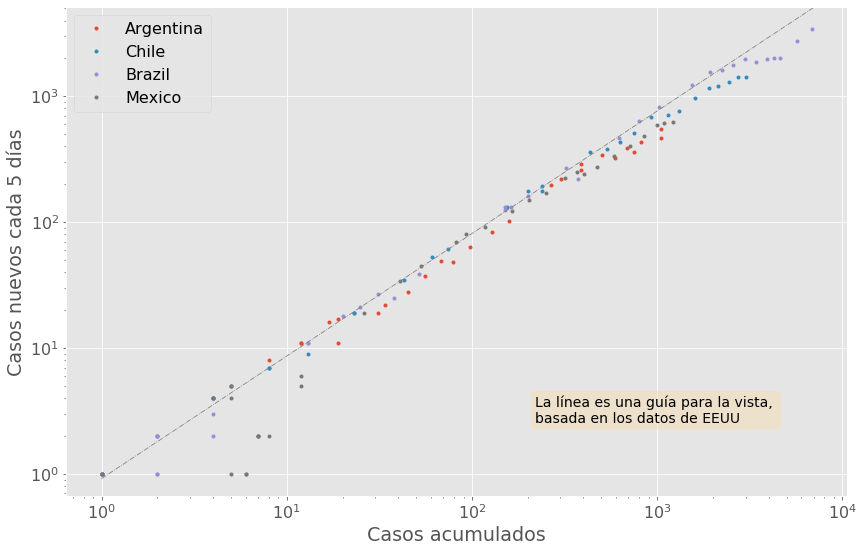

In [42]:
countries = ['Argentina', 'Chile', 'Brazil', 'Mexico']
fig, ax = plt.subplots(1)
for country in countries:
    ax.plot(sick_data[country], new_cases_5_days[country],  '.')
ax.set_ylabel('Casos nuevos cada 5 días')
ax.set_xlabel('Casos acumulados')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(countries)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot((1, 1E6), 10**np.polyval(us_fit, (0, 6)), '-.', linewidth=.8, color='grey')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
text = 'La línea es una guía para la vista, \nbasada en los datos de EEUU'
t = ax.text(.6, .15, text, transform=ax.transAxes, fontsize=14, bbox=props)
if SAVE_FIGURES:
    plt.savefig('Figures/Es/Latin_America_Log_Log_New_Cumulative_5_days.png')

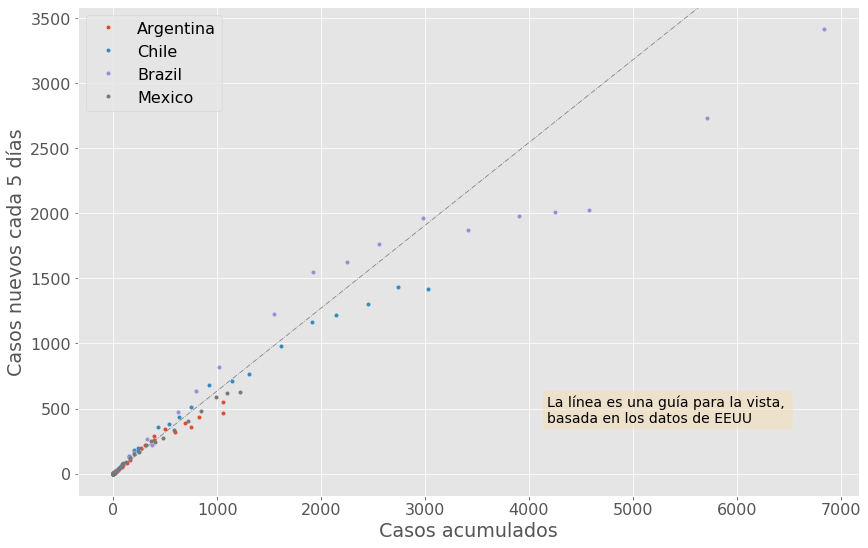

In [43]:
countries = ['Argentina', 'Chile', 'Brazil', 'Mexico']
fig, ax = plt.subplots(1)
for country in countries:
    ax.plot(sick_data[country], new_cases_5_days[country],  '.')
ax.set_ylabel('Casos nuevos cada 5 días')
ax.set_xlabel('Casos acumulados')
ax.legend(countries)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot((1, 1E6), 10**np.polyval(us_fit, (0, 6)), '-.', linewidth=.8, color='grey')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
text = 'La línea es una guía para la vista, \nbasada en los datos de EEUU'
t = ax.text(.6, .15, text, transform=ax.transAxes, fontsize=14, bbox=props)
if SAVE_FIGURES:
    plt.savefig('Figures/Es/Latin_America_Lin_Lin_New_Cumulative_5_days.png')

## Deaths instead of confirmed cases
The number of deaths may be a better parameter to judge the evolution of the epidemic, since it is less prone to sampling biases. However, it has to be noted that not all countries use the same process to report deaths related to Covid-19. Also, the number of deaths may have a delay of up to 2 weeks compared to the number of confirmed cases. 

However, the exponential growth of both curves is also evident from the log-log plots, at least, for some countries such as **Italy**, **Spain**, and **Switzerland**

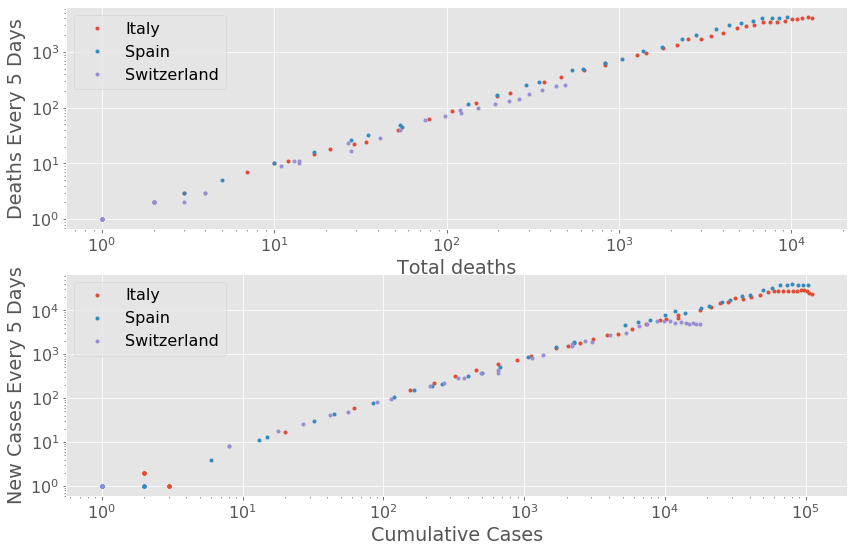

In [44]:
countries = ['Italy', 'Spain', 'Switzerland']
fig, ax = plt.subplots(2, 1)
for country in countries:
    ax[0].plot(deaths_data[country], new_deads_5_days[country],  '.')
    ax[1].plot(sick_data[country], new_cases_5_days[country],  '.')
ax[0].set_ylabel('Deaths Every 5 Days')
ax[0].set_xlabel('Total deaths')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend(countries)
ax[1].set_ylabel('New Cases Every 5 Days')
ax[1].set_xlabel('Cumulative Cases')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(countries)
if SAVE_FIGURES:
    plt.savefig('Figures/Europe_Deaths_Log_Log_New_Cumulative_5_days.png')

## Comparing deaths and cases
Both the number of deaths and the number of cases follow an exponential growth. This means that if we plot one versus the other, there should be a linear relationship. 

**Idea**: there may be some information regarding the sampling biases in different countries if we compare the slopes of the plots. 

First, let's do some exploratory visualization

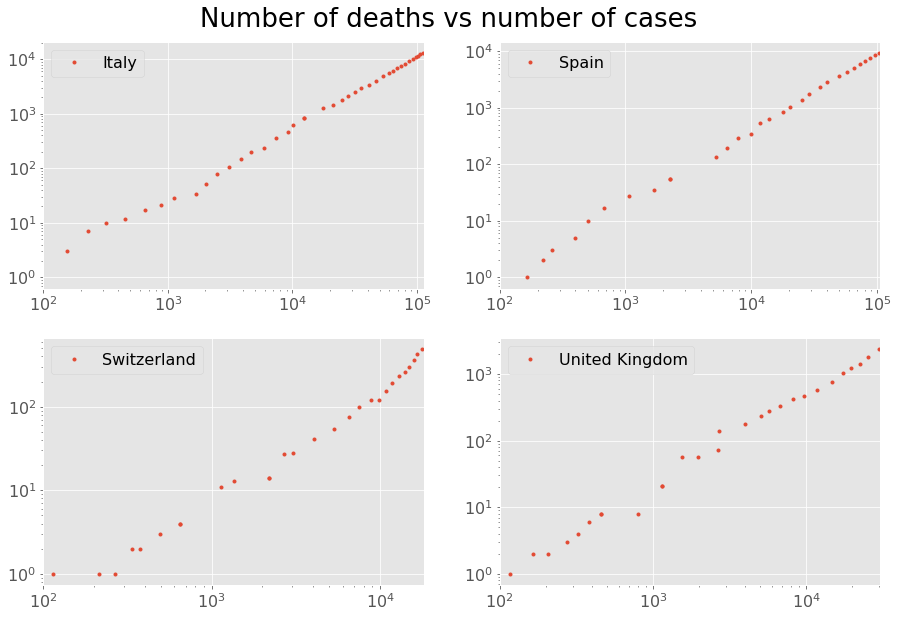

In [45]:
countries = ['Italy', 'Spain', 'Switzerland', 'United Kingdom']
fig = plt.figure(figsize=(15, 10))
# fig.suptitle(, fontsize=16)
fig.text(0.5, 0.90,'Number of deaths vs number of cases', transform=fig.transFigure, horizontalalignment='center', fontsize=26)
for i, country in enumerate(countries):
    ax = plt.subplot(int(len(countries)/2), 2, i+1)
    ax.plot(sick_data[country], deaths_data[country], '.')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(100, 1.02*max(sick_data[country]))
    ax.legend([country])
# ax[0].set_ylabel('Deaths Every 5 Days')
# ax[0].set_xlabel('Total deaths')
if SAVE_FIGURES:
    plt.savefig('Figures/Europe_Deaths_Log_Log_Deaths_vs_Cases.png')

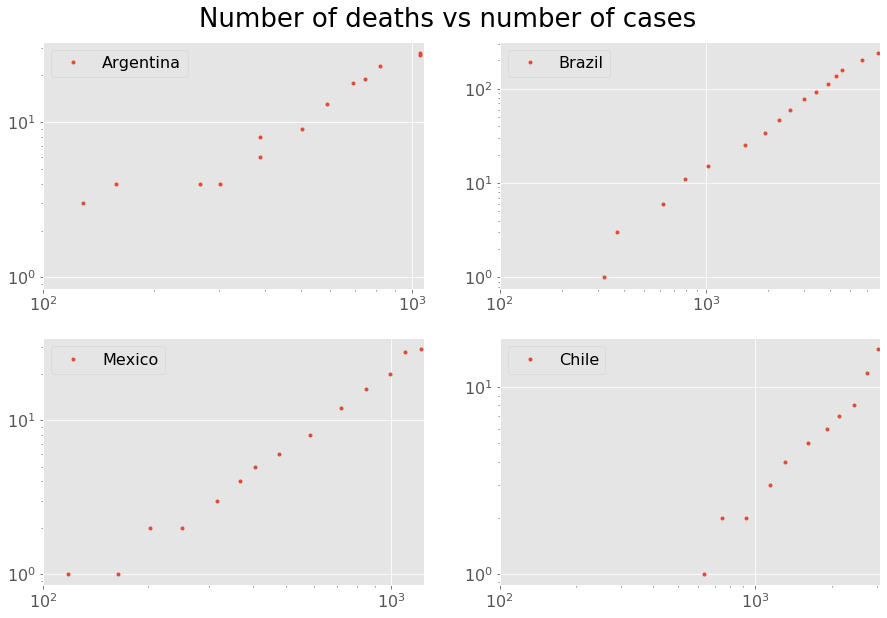

In [46]:
countries = ['Argentina', 'Brazil', 'Mexico', 'Chile']
fig = plt.figure(figsize=(15, 10))
# fig.suptitle(, fontsize=16)
fig.text(0.5, 0.90,'Number of deaths vs number of cases', transform=fig.transFigure, horizontalalignment='center', fontsize=26)
for i, country in enumerate(countries):
    ax = plt.subplot(int(len(countries)/2), 2, i+1)
    ax.plot(sick_data[country], deaths_data[country], '.')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(100, 1.02*max(sick_data[country]))
    ax.legend([country])
# ax[0].set_ylabel('Deaths Every 5 Days')
# ax[0].set_xlabel('Total deaths')
if SAVE_FIGURES:
    plt.savefig('Figures/Latin_America_Deaths_Log_Log_Deaths_vs_Cases.png')

At hinsight, it is possible to see that the slopes of every country are slightly different from each other, so there may be some relevant information in there, which may be worth exploring more carefully. Also, let's see what happens with countries with a clear non-exponential behaviour, such as **China** and **South Korea**

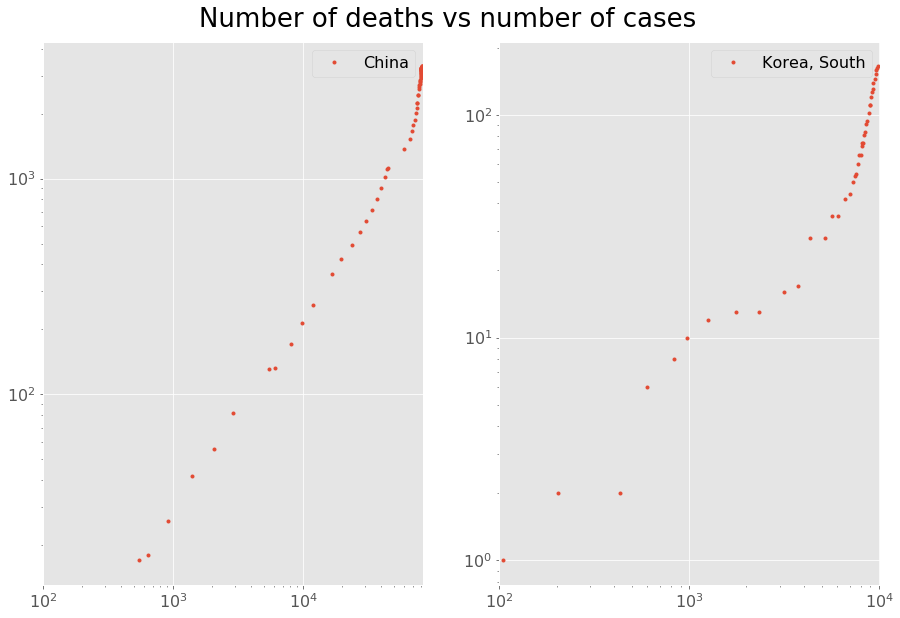

In [47]:
countries = ['China', 'Korea, South']
fig = plt.figure(figsize=(15, 10))
fig.text(0.5, 0.90,'Number of deaths vs number of cases', transform=fig.transFigure, horizontalalignment='center', fontsize=26)
for i, country in enumerate(countries):
    ax = plt.subplot(int(len(countries)/2), 2, i+1)
    ax.plot(sick_data[country], deaths_data[country], '.')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(100, 1.02*max(sick_data[country]))
    ax.legend([country])
# ax[0].set_ylabel('Deaths Every 5 Days')
# ax[0].set_xlabel('Total deaths')
if SAVE_FIGURES:
    plt.savefig('Figures/China_SK_Deaths_vs_Cases_Log_Log.png')

As expected, the number of deaths keeps growing even after the number of cases stalls. 

**TODO**: It is better to visualize data with the axes flipped, in this way a plateau will be formed instead of a divergence. Even if the information is the same, makes it clearer what is going on. 

## Number of new cases vs number of deaths past days
Another useful analysis is directly the two derivatives. Instead of looking at the accumulated number of cases and deaths, we can look at the change of both quantities. However, these data will move on the 2D plane according to the time. Therefore, we must encode time in the images. 

I chose to use a colorbar that represents time. Darker colors are the past, while bright colors are the present. In this way you can see, for example, where China started and where is it now. 

We can also **Compare the US to China**, and see that the growth is still going on. While in countries such as **Italy**, we can see that both the number of new cases and the number of deaths in the past 5 days are decreasing. In **Spain**, however, while the number of new cases is not gowing, the number of deaths is still growing. 

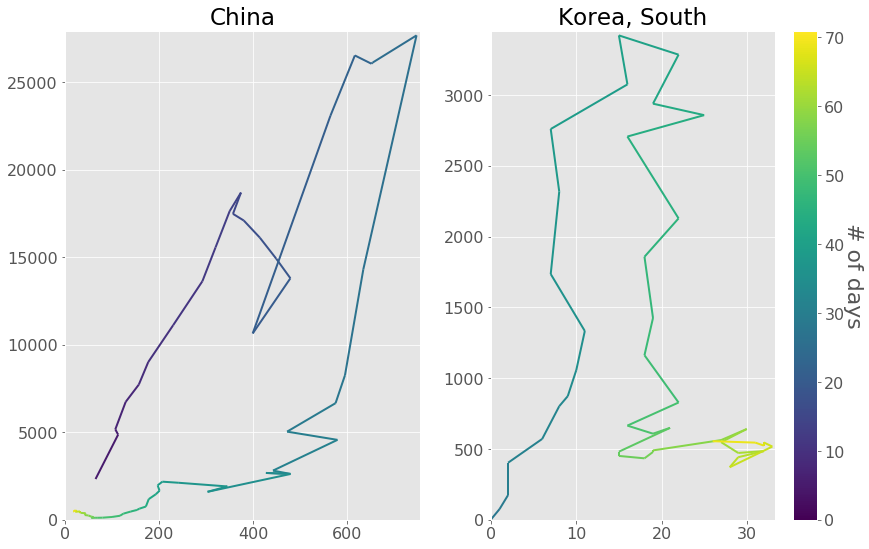

In [48]:
countries = ['China', 'Korea, South']
# fig = plt.figure(figsize=(15, 10))
fig.text(0.5, 0.90,'Number number of cases vs number of deaths ', transform=fig.transFigure, horizontalalignment='center', fontsize=26)
for i, country in enumerate(countries):
    ax = plt.subplot(int(len(countries)/2), 2, i+1)
    x = new_deads_5_days[country]
    y = new_cases_5_days[country]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(0, len(x))
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    lc.set_array(np.arange(0, len(x)))
    lc.set_linewidth(2)
    line = ax.add_collection(lc)
    ax.set_ylim(0, 1.01*np.nanmax(new_cases_5_days[country]))
    ax.set_xlim(0, 1.01*np.nanmax(new_deads_5_days[country]))
    ax.set_title(country)

cbar = fig.colorbar(line, ax=ax)
cbar.ax.get_yaxis().labelpad = 18
cbar.ax.set_ylabel('# of days', rotation=270, fontsize=22)
fig.text(0.5, 0.05,'Number of deaths every 5 days ', transform=fig.transFigure, horizontalalignment='center', fontsize=18)
fig.text(0.05, 0.5,'Number of new cases every 5 days ', transform=fig.transFigure, verticalalignment='center', fontsize=18, rotation=90)
if SAVE_FIGURES:
    plt.savefig('Figures/China_SK_Deaths_vs_Cases_5_days_Lin_Lin.png')

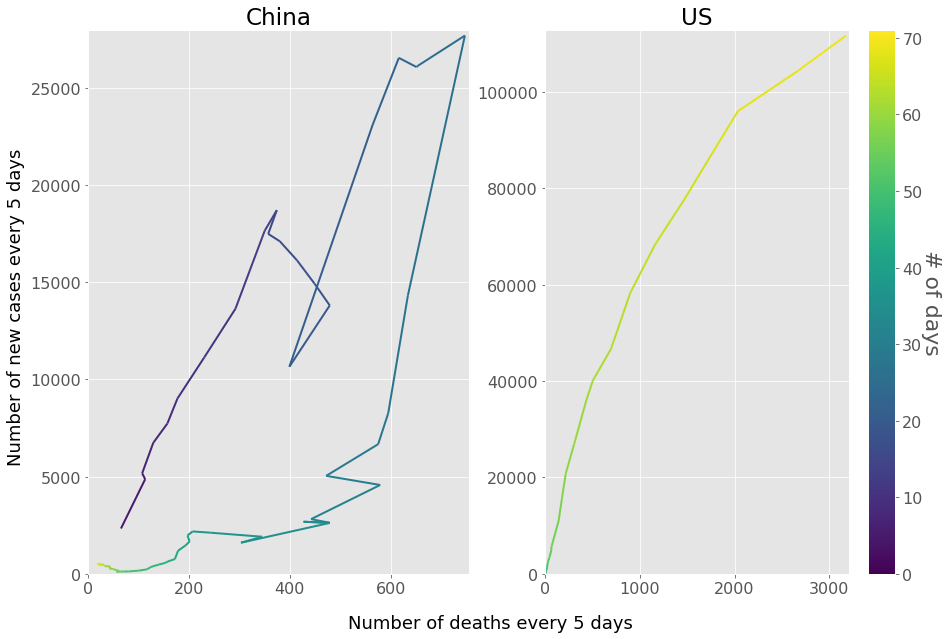

In [49]:
countries = ['China', 'US']
fig = plt.figure(figsize=(15, 10))
# fig.text(0.5, 0.90,'Number number of cases vs number of deaths ', transform=fig.transFigure, horizontalalignment='center', fontsize=26)
for i, country in enumerate(countries):
    ax = plt.subplot(int(len(countries)/2), 2, i+1)
    x = new_deads_5_days[country]
    y = new_cases_5_days[country]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(0, len(x))
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    lc.set_array(np.arange(0, len(x)))
    lc.set_linewidth(2)
    line = ax.add_collection(lc)
    ax.set_ylim(0, 1.01*np.nanmax(new_cases_5_days[country]))
    ax.set_xlim(0, 1.01*np.nanmax(new_deads_5_days[country]))
    ax.set_title(country)

cbar = fig.colorbar(line, ax=ax)
cbar.ax.get_yaxis().labelpad = 18
cbar.ax.set_ylabel('# of days', rotation=270, fontsize=22)
fig.text(0.5, 0.05,'Number of deaths every 5 days ', transform=fig.transFigure, horizontalalignment='center', fontsize=18)
fig.text(0.05, 0.5,'Number of new cases every 5 days ', transform=fig.transFigure, verticalalignment='center', fontsize=18, rotation=90)
if SAVE_FIGURES:
    plt.savefig('Figures/China_US_Deaths_vs_Cases_5_days_Lin_Lin.png')

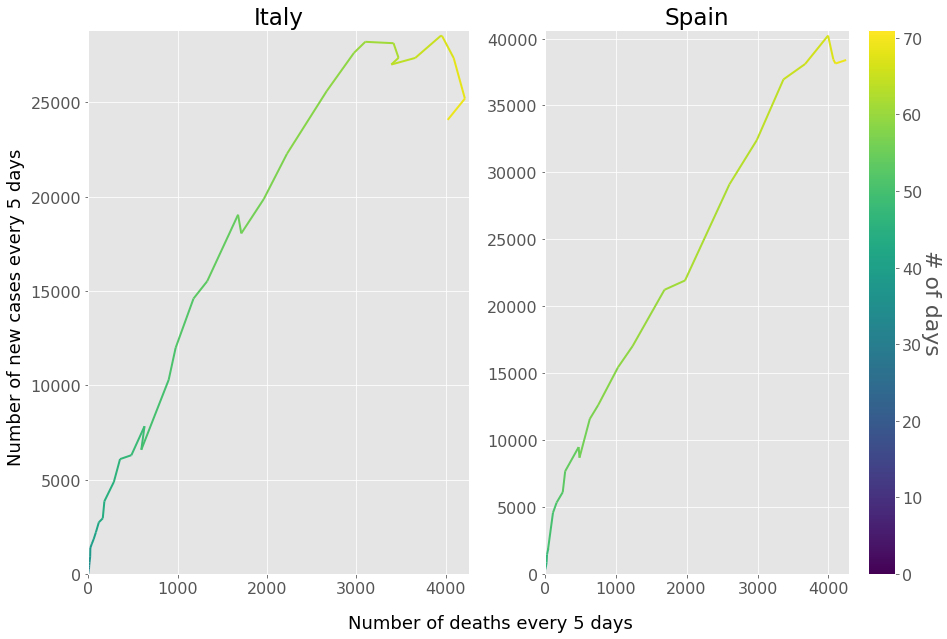

In [50]:
countries = ['Italy', 'Spain']
fig = plt.figure(figsize=(15, 10))
for i, country in enumerate(countries):
    ax = plt.subplot(int(len(countries)/2), 2, i+1)
    x = new_deads_5_days[country]
    y = new_cases_5_days[country]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(0, len(x))
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    lc.set_array(np.arange(0, len(x)))
    lc.set_linewidth(2)
    line = ax.add_collection(lc)
    ax.set_ylim(0, 1.01*np.nanmax(new_cases_5_days[country]))
    ax.set_xlim(0, 1.01*np.nanmax(new_deads_5_days[country]))
    ax.set_title(country)

cbar = fig.colorbar(line, ax=ax)
cbar.ax.get_yaxis().labelpad = 18
cbar.ax.set_ylabel('# of days', rotation=270, fontsize=22)
fig.text(0.5, 0.05,'Number of deaths every 5 days ', transform=fig.transFigure, horizontalalignment='center', fontsize=18)
fig.text(0.05, 0.5,'Number of new cases every 5 days ', transform=fig.transFigure, verticalalignment='center', fontsize=18, rotation=90)
if SAVE_FIGURES:
    plt.savefig('Figures/Ita_Spa_Deaths_vs_Cases_5_days_Lin_Lin.png')

## Time delay between total number of cases and deaths
I have focused mostly on number of cases, because I made an emotional decision of not looking at the number of deaths in different countries. However, it is also important to look at those numbers to understand the intertia that any measure will have. If the exponential growth is slowed down, the number of deaths will keep increasing for a while. 

The only country which can be used for this, right now, is China, because it is the only one that manages to virtually stopped the increase in the number of cases.

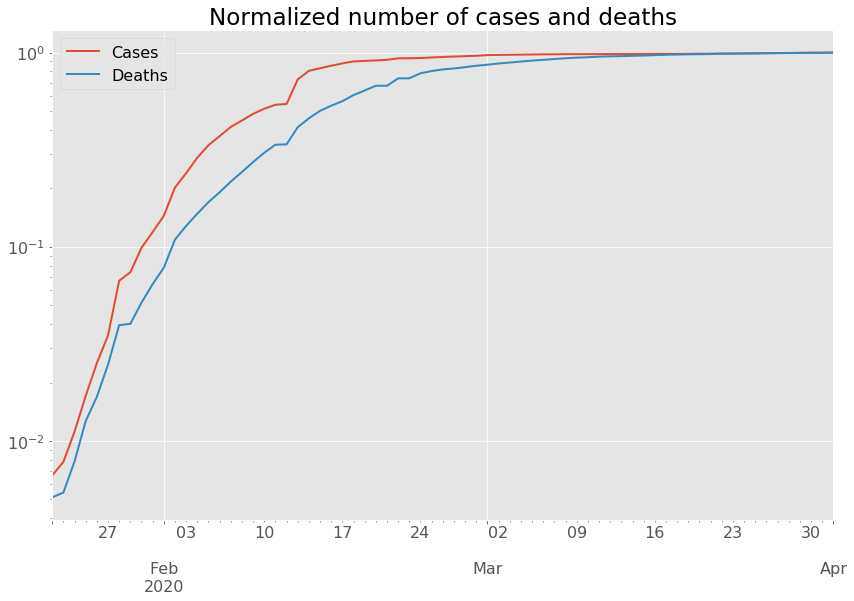

In [51]:
data = sick_data['China']/max(sick_data['China'])
ddata = deaths_data['China']/max(deaths_data['China'])
ax = data.plot()
ddata.plot(ax=ax)
ax.set_yscale('log')
ax.legend(['Cases', 'Deaths'])
ax.set_title('Normalized number of cases and deaths')
if SAVE_FIGURES:
    plt.savefig('Figures/China_Death_Sick_Comparison_Normalized.png')

## Fitting
Assuming the number of cases grows exponentially, can we actually learn something out of the fitting? 

#### Idea
Hopefully, the exponential growth will slow down. Exponential growth means that the derivative of the function is proportional to the function itself. If we evaluate this proportionality over time and see a decrease, it may be a hint that we are going in a good direction. 

If we see the log-log plots of new cases vs cumulative cases, we can fit a linear function to a rolling group of points, and see if there is any variation in that coefficient. 

/opt/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/covid/lib/python3.8/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


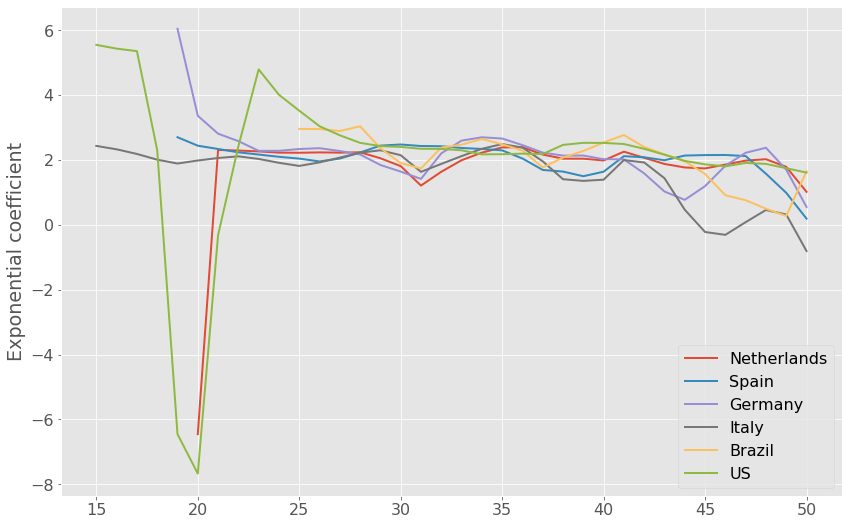

In [52]:
countries = ['Netherlands', 'Spain', 'Germany', 'Italy', 'Brazil', 'US']
window_size = 5

coeff = pd.DataFrame(columns=countries)
c = {country: [] for country in countries}
data_points = len(new_cases_5_days)-window_size

for i in range(15, data_points):
    for country in countries:
        sd = sick_data[country][i:i+window_size]
        nc = new_cases_5_days[country][i:i+window_size]
        if np.sum(nc) > 15:            
            try:
                p = np.polyfit(
                    np.log10(sd),
                    np.log10(nc),
                    1,
                )
            except:
                pass
            c[country].append(p[0]*np.log(10.))
        else:
            c[country].append(np.NaN)

coeff = coeff.append(pd.DataFrame.from_dict(c))
ax = coeff.plot()
ax.set_xlabel('')
ax.set_ylabel('Exponential coefficient')
if SAVE_FIGURES:
    plt.savefig('Figures/Exponential_coefficients_several_countries.png')

In [53]:
list(confirmed_data)

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burma',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 

In [54]:
## Let's compile a new README file every time
with open('readme_temp.md','r') as f:
    text = f.read()
    with open('README.md', 'w') as readme:
        readme.write(text.format(date=datetime.now()))

In [55]:
sick_data['Argentina']['2020-03-22']

266

Finally, let's print the list of available countries so we know what other data we can explore.

In [56]:
for case, country in zip(new_cases.loc['2020-03-26'], list(new_cases)):
    print(country, case)

Afghanistan 10.0
Albania 28.0
Algeria 65.0
Andorra 36.0
Angola 1.0
Antigua and Barbuda 4.0
Argentina 115.0
Armenia 25.0
Australia 446.0
Austria 1321.0
Azerbaijan 29.0
Bahamas 4.0
Bahrain 39.0
Bangladesh 5.0
Barbados 0.0
Belarus 0.0
Belgium 1298.0
Belize 0.0
Benin 0.0
Bhutan 0.0
Bolivia 11.0
Bosnia and Herzegovina 15.0
Botswana 0.0
Brazil 431.0
Brunei 5.0
Bulgaria 22.0
Burkina Faso 6.0
Burma 0.0
Burundi 0.0
Cabo Verde 0.0
Cambodia 0.0
Cameroon 0.0
Canada 791.0
Central African Republic 0.0
Chad 0.0
Chile 164.0
China 121.0
Colombia 21.0
Congo (Brazzaville) 0.0
Congo (Kinshasa) 3.0
Costa Rica 30.0
Cote d'Ivoire 16.0
Croatia 53.0
Cuba 10.0
Cyprus 14.0
Czechia 271.0
Denmark 161.0
Diamond Princess 0.0
Djibouti 0.0
Dominica 4.0
Dominican Republic 96.0
Ecuador 230.0
Egypt 39.0
El Salvador 4.0
Equatorial Guinea 3.0
Eritrea 2.0
Estonia 134.0
Eswatini 2.0
Ethiopia 0.0
Fiji 0.0
Finland 78.0
France 3951.0
Gabon 1.0
Gambia 0.0
Georgia 4.0
Germany 6615.0
Ghana 39.0
Greece 71.0
Grenada 6.0
Guatemala 1.